### Collaborators
- Group 2:
    - Flores, Regina
    - Malenab, Cesar
    - Pedernal, Emmanuel

[Census Dataset](https://archive.ics.uci.edu/dataset/2/adult)

- What profiles/attributes allow us to distinguish those who earn more than 50k to those who are not?

**Rubric:**
- Correct preprocessing
- Insightful EDA
- Propose predictive/prescriptive models based on similar studies. Proposal only, NO MODELING. We didn't discuss any modeling technique that's why you need to read papers.
- Notebook/Code
- Presentation meant for a CEO or someone in charge who's meant to understand your topic

# Installations

In [1]:
%%capture

! pip install ucimlrepo
! pip install seaborn --upgrade

# Declarations

In [2]:
from ucimlrepo import fetch_ucirepo, list_available_datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Data Preprocessing

## Data Source

In [3]:
# Fetch dataset
adult_raw = fetch_ucirepo(id=2)

X = adult_raw.data.features
y = adult_raw.data.targets

adult = pd.concat([adult_raw.data.features, adult_raw.data.targets], axis=1)
adult.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

## Check for completeness

In [4]:
#get no of nunique, cardinality, % of NaNs and Uknowns
def analyse_cats(df, cat_cols):
    d = pd.DataFrame()
    cl = []; u=[]; s=[]; nans=[]; unknown=[]
    for c in cat_cols:
        cl.append(c);
        u.append(df[c].unique());
        s.append(df[c].unique().size);
        nans.append(round((df[c].isnull().sum()/(len(adult))*100), 2))
        unknown.append(round((df[c].astype(str).str.strip().eq("?").sum()/(len(adult))*100), 2))
    d["Feature"] = cl; d["Uniques"] = u; d["Cardinality"] = s; d["% Share of Nans"] = nans; d["% Share of Unknown (?)"] = unknown
    d["% Share of Nans or Unknowns (?)"] = d["% Share of Nans"] + d["% Share of Unknown (?)"]
    return d

analyse_cats(adult, adult.columns)

Feature  \
0              age   
1        workclass   
2           fnlwgt   
3        education   
4    education-num   
5   marital-status   
6       occupation   
7     relationship   
8             race   
9              sex   
10    capital-gain   
11    capital-loss   
12  hours-per-week   
13  native-country   
14          income   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Uniques  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                [39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 40, 34, 25, 43, 54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 18, 47, 46, 36, 79, 27, 67, 33, 76, 17, 55, 61, 70, 64, 71, 68, 66, 51, 58, 26, 60, 90, 75, 65, 77, 62, 63, 80, 72, 74, 69, 73, 81, 78, 88, 82, 83, 84, 85, 86, 87, 89]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [State-gov, Self-emp-not-inc, Private, Federal-gov, Local-gov, ?, Self-emp-inc, Without-pay, Never-worked, nan]   
2   [77516, 83311, 215646, 234721, 338409, 284582, 160187, 209642, 45781, 159449, 280464, 141297, 122272, 205019, 121772, 245487, 176756, 186824, 28887, 292175, 193524, 302146, 76845, 117037, 109015, 216851, 168294, 180211, 367260, 193366, 190709, 266015, 386940, 59951, 311512, 242406, 197200, 544091, 84154, 265477, 507875, 88506, 172987, 94638, 289980, 337895, 144361, 128354, 101603, 271466, 32275, 226956, 51835, 251585, 109832, 237993, 216666, 56352, 147372, 188146, 59496, 293936, 149640, 116632, 105598, 155537, 183175, 169846, 191681, 200681, 101509, 309974, 162298, 211678, 124744, 213921, 32214, 212759, 309634, 125927, 446839, 276515, 51618, 159937, 343591, 346253, 268234, 202051, 54334, 410867, 249977, 286730, 212563, 117747, 226296, 115585, 191277, 202683, 171095, 249409, ...]   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [5]:
# Count how many rows have at least one null or unknown (?) value
ctr = 0;
for i in range(0, len(adult)):
    if ((adult.iloc[i].isnull().any()) or (adult.iloc[i].astype(str).str.strip().eq("?").any())):
        ctr +=1

print('{}/{} = {}'.format(ctr, len(adult), round(((ctr)/len(adult))*100, 2)))

3620/48842 = 7.41


In [6]:
# Describe all columns
adult.describe(include="all").T

count unique                 top   freq           mean  \
age             48842.0    NaN                 NaN    NaN      38.643585   
workclass         47879      9             Private  33906            NaN   
fnlwgt          48842.0    NaN                 NaN    NaN  189664.134597   
education         48842     16             HS-grad  15784            NaN   
education-num   48842.0    NaN                 NaN    NaN      10.078089   
marital-status    48842      7  Married-civ-spouse  22379            NaN   
occupation        47876     15      Prof-specialty   6172            NaN   
relationship      48842      6             Husband  19716            NaN   
race              48842      5               White  41762            NaN   
sex               48842      2                Male  32650            NaN   
capital-gain    48842.0    NaN                 NaN    NaN    1079.067626   
capital-loss    48842.0    NaN                 NaN    NaN      87.502314   
hours-per-week  48842.0    NaN                 NaN    NaN      40.422382   
native-country    48568     42       United-States  43832            NaN   
income            48842      4               <=50K  24720            NaN   

                          std      min       25%       50%       75%  \
age                  13.71051     17.0      28.0      37.0      48.0   
workclass                 NaN      NaN       NaN       NaN       NaN   
fnlwgt          105604.025423  12285.0  117550.5  178144.5  237642.0   
education                 NaN      NaN       NaN       NaN       NaN   
education-num        2.570973      1.0       9.0      10.0      12.0   
marital-status            NaN      NaN       NaN       NaN       NaN   
occupation                NaN      NaN       NaN       NaN       NaN   
relationship              NaN      NaN       NaN       NaN       NaN   
race                      NaN      NaN       NaN       NaN       NaN   
sex                       NaN      NaN       NaN       NaN       NaN   
capital-gain      7452.019058      0.0       0.0       0.0       0.0   
capital-loss       403.004552      0.0       0.0       0.0       0.0   
hours-per-week      12.391444      1.0      40.0      40.0      45.0   
native-country            NaN      NaN       NaN       NaN       NaN   
income                    NaN      NaN       NaN       NaN       NaN   

                      max  
age                  90.0  
workclass             NaN  
fnlwgt          1490400.0  
education             NaN  
education-num        16.0  
marital-status        NaN  
occupation            NaN  
relationship          NaN  
race                  NaN  
sex                   NaN  
capital-gain      99999.0  
capital-loss       4356.0  
hours-per-week       99.0  
native-country        NaN  
income                NaN

### Findings
- Max share of Nans and Unknowns per attribute is **5.75%**
- The number of incomplete rows (have at least one Nan or Unknown) is **7.41%**
- High cardinality attributes, for possible re-grouping:
  - `age`, `workclass`, `education`, `occupation`, `hours-per-week`, `native-country`
- Attributes for possible dropping:
  - `education-num` : ordinal equivalent of `education`
  - `fnlwgt` : high cardinality, final weight assigned by survey
  - `capital-gain`, `capital-loss` : high cardinality, highly skewed, no context given
  - `relationship`: repetitive with `marital-status` and `sex` (ie. Husband = Married + Male)

## Data Reduction

In [7]:
adult.drop(columns=["fnlwgt", "education-num", "capital-gain", "capital-loss", "native-country", "relationship"],
           inplace=True)

## Possible Re-grouping
[Reference for Age](https://www2.census.gov/library/publications/decennial/2020/census-briefs/c2020br-06.pdf)
- Grouping:
  - Under 18 years: Under 5 years, 5 to 17 years
  - 18 to 44 years: 18 to 24 years, 25 to 44 years
  - 45 to 64 years: 45 to 54 years, 55 to 64 years
  - 65 years and over: 65 to 74 years, 75 to 84 years, 85 years and over

[Reference for Work Class](https://www.census.gov/topics/employment/industry-occupation/about/class-of-worker.html)

- Grouping:
  - Private Sector Employee
  - Government Employee
  - Self-Employed Or Other

[Reference for Education](https://www2.census.gov/programs-surveys/acs/about/qbyqfact/EducationalAttainment_FieldofDegree.pdf)
- Grouping:
  - No Schooling Completed
  - Nursery or Pre-school Through Grade 12
  - High School Graduate
  - College or Some College
  - After Bachelor's Degree

[Reference for Occupation, see Appendix B1, page 157](https://www2.census.gov/programs-surveys/cps/techdocs/cpsmar23.pdf)
- Grouping:
  - Management, business, and financial
  - Professional and related
  - Service
  - Sales and related
  - Office and administrative support
  - Farming, fishing, and forestry
  - Construction and extraction
  - Installation, maintenance, and repair
  - Production
  - Transportation and material moving
  - Military specific
  
[Hours per Week]
- Grouping: (bins)
  - '0-20 hours'
  - '20-40 hours'
  - '40-60 hours'
  - '>60 hours'

[Native Country]
  - Top 5; but also highly skewed. Candidate for dropping


In [8]:
# Use reference to re-group age

adult.loc[adult["age"].lt(5), 'age-group'] = "Under 5 years"
adult.loc[adult["age"].between(5, 17, inclusive="both"), 'age-group'] = "5 to 17 years"
adult.loc[adult["age"].between(18, 24, inclusive="both"), 'age-group'] = "18 to 24 years"
adult.loc[adult["age"].between(25, 44, inclusive="both"), 'age-group'] = "25 to 44 years"
adult.loc[adult["age"].between(45, 54, inclusive="both"), 'age-group'] = "45 to 54 years"
adult.loc[adult["age"].between(55, 64, inclusive="both"), 'age-group'] = "55 to 64 years"
adult.loc[adult["age"].between(65, 74, inclusive="both"), 'age-group'] = "65 to 74 years"
adult.loc[adult["age"].between(75, 84, inclusive="both"), 'age-group'] = "75 to 84 years"
adult.loc[adult["age"].gt(84), 'age-group'] = "85 years and over"

# Once re-grouped, drop original column
adult.drop(columns=["age"], inplace=True)

In [9]:
# Use reference to re-group work class

adult['workclass-group'] = "Unknown"
adult.loc[adult["workclass"].isin(["Private"]), 'workclass-group'] = "Private Sector Employee"
adult.loc[adult["workclass"].isin(["State-gov", "Federal-gov", "Local-gov"]), 'workclass-group'] = "Government Employee"
adult.loc[adult["workclass"].isin(["Self-emp-inc", "Self-emp-not-inc", "Without-pay"]), 'workclass-group'] = "Self-employed or Other"

# Once re-grouped, drop original column
adult.drop(columns=["workclass"], inplace=True)

In [10]:
# Use reference to re-group Education

adult['education-group'] = "No Schooling Completed"
adult.loc[adult["education"].isin(["Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th", "12th"]), 'education-group'] = "Nursery or Pre-school Through Grade 12"
adult.loc[adult["education"].isin(["HS-grad"]), 'education-group'] = "High School Graduate"
adult.loc[adult["education"].isin(["Bachelors", "Some-college", "Assoc-acdm", "Assoc-voc"]), 'education-group'] = "College or Some College"
adult.loc[adult["education"].isin(["Masters", "Doctorate", "Prof-school"]), 'education-group'] = "After Bachelor\'s Degree"

# Once re-grouped, drop original column
adult.drop(columns=["education"], inplace=True)

In [11]:
# Use reference to re-group Occupation

adult['occupation-group'] = "Unknown"
adult.loc[adult["occupation"].isin(["Exec-managerial"]), 'occupation-group'] = "Management, business, and financial"
adult.loc[adult["occupation"].isin(["Prof-specialty", "Prof-school"]), 'occupation-group'] = "Professional and related"
adult.loc[adult["occupation"].isin(["Adm-clerical", "Tech-support"]), 'occupation-group'] = "Office and administrative support"
adult.loc[adult["occupation"].isin(["Sales"]), 'occupation-group'] = "Sales and related"
adult.loc[adult["occupation"].isin(["Farming-fishing"]), 'occupation-group'] = "Farming, fishing, and forestry"
adult.loc[adult["occupation"].isin(["Transport-moving"]), 'occupation-group'] = "Transportation and material moving"
adult.loc[adult["occupation"].isin(["Craft-repair"]), 'occupation-group'] = "Installation, maintenance, and repair"
adult.loc[adult["occupation"].isin(["Handlers-cleaners", "Other-service"]), 'occupation-group'] = "Service"
adult.loc[adult["occupation"].isin(["Machine-op-inspct"]), 'occupation-group'] = "Construction and extraction"
adult.loc[adult["occupation"].isin(["Protective-serv", "Armed-Forces", "Priv-house-serv"]), 'occupation-group'] = "Military specific"

# Once re-grouped, drop original column
adult.drop(columns=["occupation"], inplace=True)

In [12]:
# Use reference to re-group Occupation

adult['marital-status-group'] = "Unknown"
adult.loc[adult["marital-status"].isin(["Married-civ-spouse", "Married-AF-spouse"]), 'marital-status-group'] = "Married"
adult.loc[adult["marital-status"].isin(["Divorced", "Married-spouse-absent", "Separated"]), 'marital-status-group'] = "Separated"
adult.loc[adult["marital-status"].isin(["Never-married"]), 'marital-status-group'] = "Never-Married"
adult.loc[adult["marital-status"].isin(["Widowed"]), 'marital-status-group'] = "Widowed"

# Once re-grouped, drop original column
adult.drop(columns=["marital-status"], inplace=True)

In [13]:
#Bin work hours by 20 hours
bin_edges = [0, 20, 40, 60, 100]
bin_labels = ['0-20 hours', '20-40 hours', '40-60 hours', '>60 hours']

adult['weekly-work-hours'] = pd.cut(adult['hours-per-week'], bins=bin_edges, labels=bin_labels)

# Once re-grouped, drop original column
adult.drop(columns=["hours-per-week"], inplace=True)

In [14]:
adult.head()

race     sex income       age-group          workclass-group  \
0  White    Male  <=50K  25 to 44 years      Government Employee   
1  White    Male  <=50K  45 to 54 years   Self-employed or Other   
2  White    Male  <=50K  25 to 44 years  Private Sector Employee   
3  Black    Male  <=50K  45 to 54 years  Private Sector Employee   
4  Black  Female  <=50K  25 to 44 years  Private Sector Employee   

                          education-group  \
0                 College or Some College   
1                 College or Some College   
2                    High School Graduate   
3  Nursery or Pre-school Through Grade 12   
4                 College or Some College   

                      occupation-group marital-status-group weekly-work-hours  
0    Office and administrative support        Never-Married       20-40 hours  
1  Management, business, and financial              Married        0-20 hours  
2                              Service            Separated       20-40 hours  
3                              Service              Married       20-40 hours  
4             Professional and related              Married       20-40 hours

## Transform Target Feature
- `<=50K` and `<=50K.` becomes 0
- `>50K` and `>50K.` becomes 1

In [15]:
# Transform targets to binary
adult['income'] = adult['income'].apply(lambda x: 0 if ((x.strip() == "<=50K") or (x.strip() == "<=50K.")) else 1)

## Re-analyse Categories

In [16]:
analyse_cats(adult, adult.columns)

Feature  \
0                  race   
1                   sex   
2                income   
3             age-group   
4       workclass-group   
5       education-group   
6      occupation-group   
7  marital-status-group   
8     weekly-work-hours   

                                                                                                                                                                                                                                                                                              Uniques  \
0                                                                                                                                                                                                                                       [White, Black, Asian-Pac-Islander, Amer-Indian-Eskimo, Other]   
1                                                                                                                                                                                                                                                                                      [Male, Female]   
2                                                                                                                                                                                                                                                                                              [0, 1]   
3                                                                                                                                                                  [25 to 44 years, 45 to 54 years, 18 to 24 years, 55 to 64 years, 75 to 84 years, 65 to 74 years, 5 to 17 years, 85 years and over]   
4                                                                                                                                                                                                                     [Government Employee, Self-employed or Other, Private Sector Employee, Unknown]   
5                                                                                                                                                                                    [College or Some College, High School Graduate, Nursery or Pre-school Through Grade 12, After Bachelor's Degree]   
6  [Office and administrative support, Management, business, and financial, Service, Professional and related, Sales and related, Installation, maintenance, and repair, Transportation and material moving, Farming, fishing, and forestry, Construction and extraction, Unknown, Military specific]   
7                                                                                                                                                                                                                                                        [Never-Married, Married, Separated, Widowed]   
8                                                                                                                                                      ['20-40 hours', '0-20 hours', '40-60 hours', '>60 hours']
Categories (4, object): ['0-20 hours' < '20-40 hours' < '40-60 hours' < '>60 hours']   

   Cardinality  % Share of Nans  % Share of Unknown (?)  \
0            5              0.0                     0.0   
1            2              0.0                     0.0   
2            2              0.0                     0.0   
3            8              0.0                     0.0   
4            4              0.0                     0.0   
5            4              0.0                     0.0   
6           11              0.0                     0.0   
7            4              0.0                     0.0   
8            4              0.0                     0.0   

   % Share of Nans or Unknowns (?)  
0                              0.0  
1                              0.0  
2                              0.0  
3                              0.0 

## Categorical and Numerical Columns

In [17]:
cat_cols = adult.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = adult.select_dtypes(include=np.number).columns.tolist()

print("{} Categorical columns: {}".format(len(cat_cols), cat_cols))
print("{} Numerical columns: {}".format(len(num_cols), num_cols))

8 Categorical columns: ['race', 'sex', 'age-group', 'workclass-group', 'education-group', 'occupation-group', 'marital-status-group', 'weekly-work-hours']
1 Numerical columns: ['income']


## Descriptive Statistics

In [18]:
# Describe all columns
adult.describe(include="all").T

count unique                                top  \
race                    48842      5                              White   
sex                     48842      2                               Male   
income                48842.0    NaN                                NaN   
age-group               48842      8                     25 to 44 years   
workclass-group         48842      4            Private Sector Employee   
education-group         48842      4            College or Some College   
occupation-group        48842     11  Office and administrative support   
marital-status-group    48842      4                            Married   
weekly-work-hours       48842      4                        20-40 hours   

                       freq      mean       std  min  25%  50%  75%  max  
race                  41762       NaN       NaN  NaN  NaN  NaN  NaN  NaN  
sex                   32650       NaN       NaN  NaN  NaN  NaN  NaN  NaN  
income                  NaN  0.239282  0.426649  0.0  0.0  0.0  0.0  1.0  
age-group             24770       NaN       NaN  NaN  NaN  NaN  NaN  NaN  
workclass-group       33906       NaN       NaN  NaN  NaN  NaN  NaN  NaN  
education-group       22565       NaN       NaN  NaN  NaN  NaN  NaN  NaN  
occupation-group       7057       NaN       NaN  NaN  NaN  NaN  NaN  NaN  
marital-status-group  22416       NaN       NaN  NaN  NaN  NaN  NaN  NaN  
weekly-work-hours     30037       NaN       NaN  NaN  NaN  NaN  NaN  NaN

# Exploratory Data Analysis

The following univariate and bivariate analysis will focus on identifying features that highly affects affluence rate (income >50k) of individuals.

In [19]:
def annotate_percentage(ax, fontsize=16):
    all_widths = [[p.get_width() for p in bars] for bars in ax.containers]

    for bars in ax.containers:
        for p in bars:
            total=sum(sum(widths) for widths in all_widths)
            percentage = f'{(100*p.get_width()/total) :.1f}%'
            ax.annotate(percentage,
                        (p.get_width(), p.get_y() + p.get_height()/ 2,),
                        xytext=(3, 0),
                        textcoords='offset points',
                        size=10,
                        ha='left',
                        va='center')

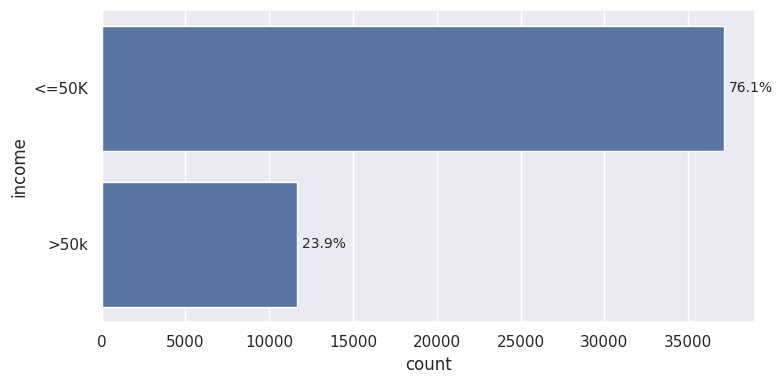

In [20]:
fig, axs = plt.subplots(figsize=(8, 4))

sns.countplot(ax=axs,
              data = adult,
              y = "income",)

# axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.set_yticklabels(["<=50K", ">50k"])

annotate_percentage(axs)
plt.tight_layout()
plt.show()

## Univariate Analysis


In [21]:
def univariate(df, feature, target):

    #contigency table
    cont_table = pd.crosstab(df[feature], df[target], margins=True,)
    cont_prob = cont_table.div(cont_table['All'], axis=0)

    fig, axs = plt.subplots(nrows=1,
                            ncols=2,
                            figsize=(16,5))
    #Affluence Rate
    sns.barplot(ax=axs[0],
                x=cont_prob.iloc[:-1][1].values*100,
                y=cont_prob.iloc[:-1][1].index,
                color="orange")
    #Feature Count
    sns.barplot(ax=axs[1],
                x=cont_table.iloc[:-1][1].values,
                y=cont_table.iloc[:-1][1].index,
                color="darkblue")

    fig.suptitle(f"Univariate Analysis of {feature}", fontsize=20)
    axs[0].set_title(f"Affluence rate given {feature}", fontsize=16, pad=10)
    axs[1].set_title(f"Feature count of {feature} with income >50k", fontsize=16, pad=10)
    axs[0].set_xlabel(f"Percentage", fontsize=12)
    axs[1].set_xlabel(f"Count", fontsize=12)

    plt.tight_layout();



### Analyze all columns

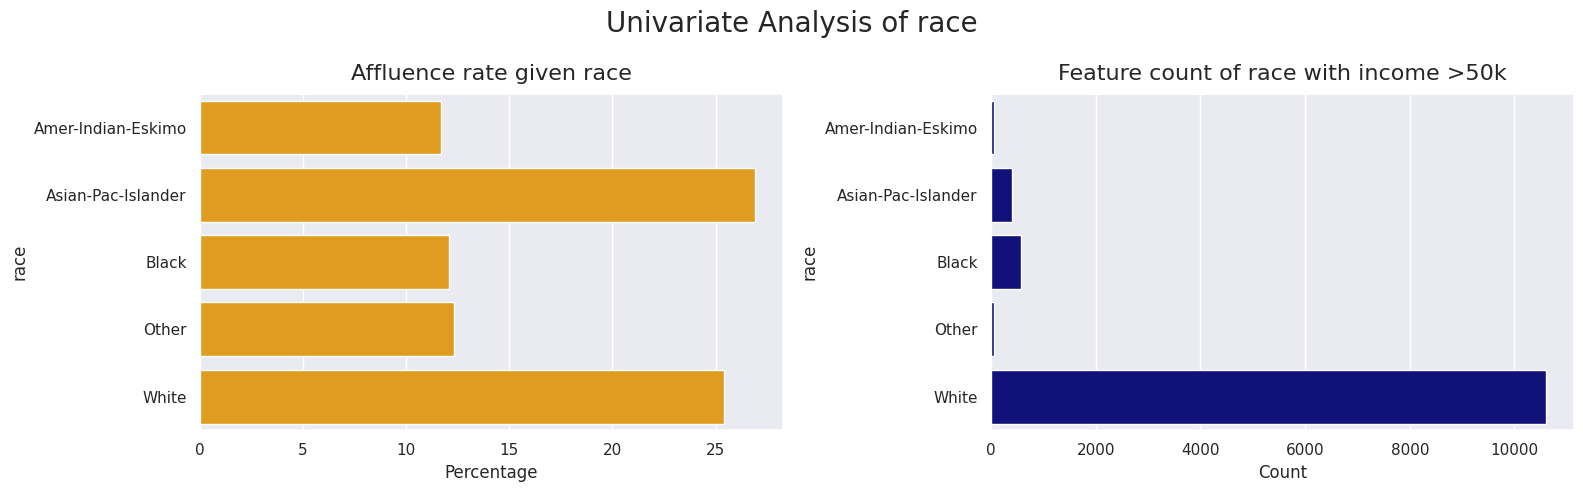

In [22]:
univariate(adult, "race", "income")

#### Insights on race

* `Asians(26.9%)` and `white(25.4%)` people are more likely to have an income of `>50k` but an increased number of data points for asians is needed to make it more statistically significant.

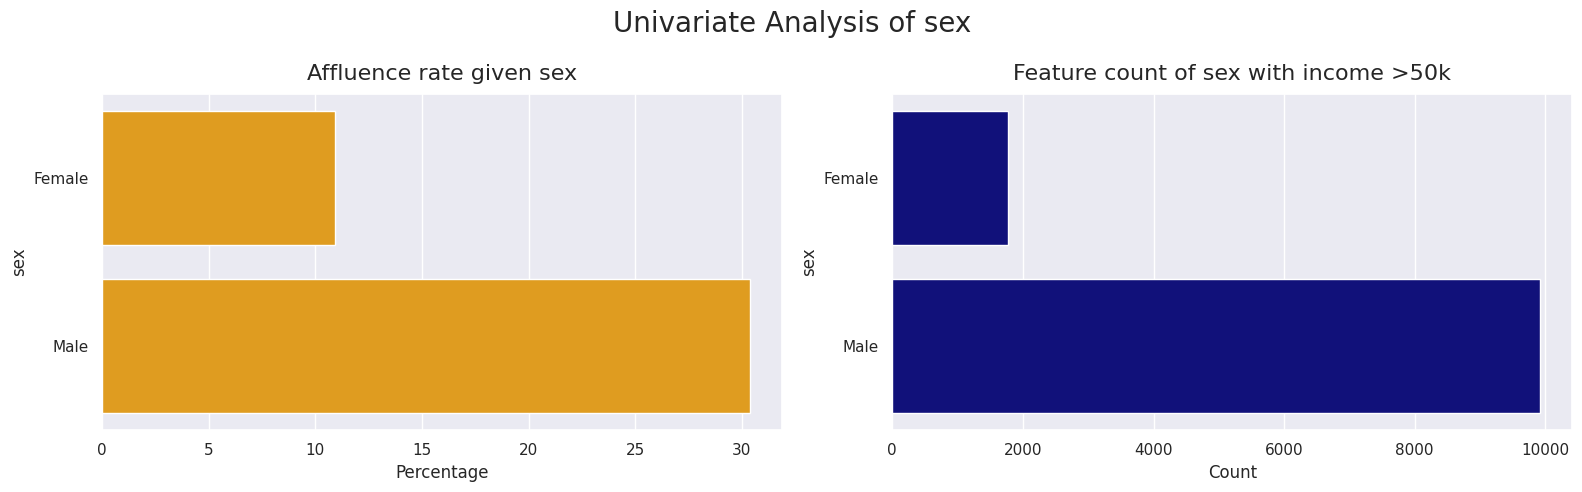

In [23]:
univariate(adult, "sex", "income")

#### Insights on sex

* `Males` have higher affluence rate than `females`.

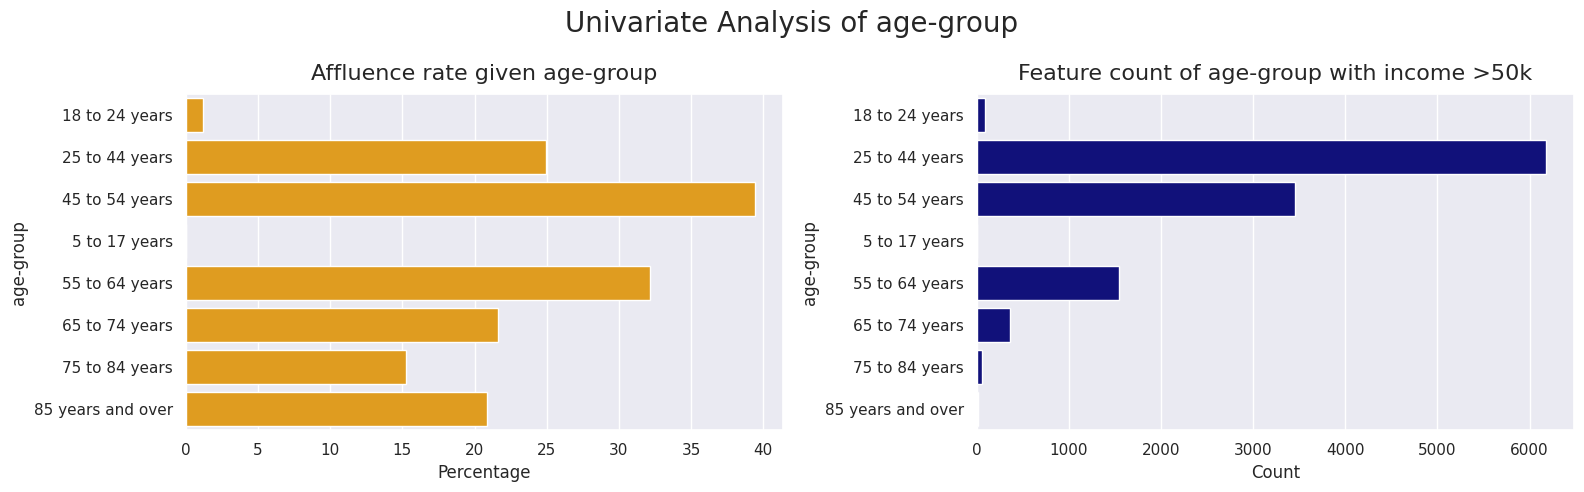

In [24]:
univariate(adult, "age-group", "income")

#### Insights on age

* Age groups between `45 to 64 years old` are more likely to have an income `>50k` with almost 40% affluence rate for `45 to 54 years old`. This is expected as people within this age group are probably more experienced compared to other age brackets.

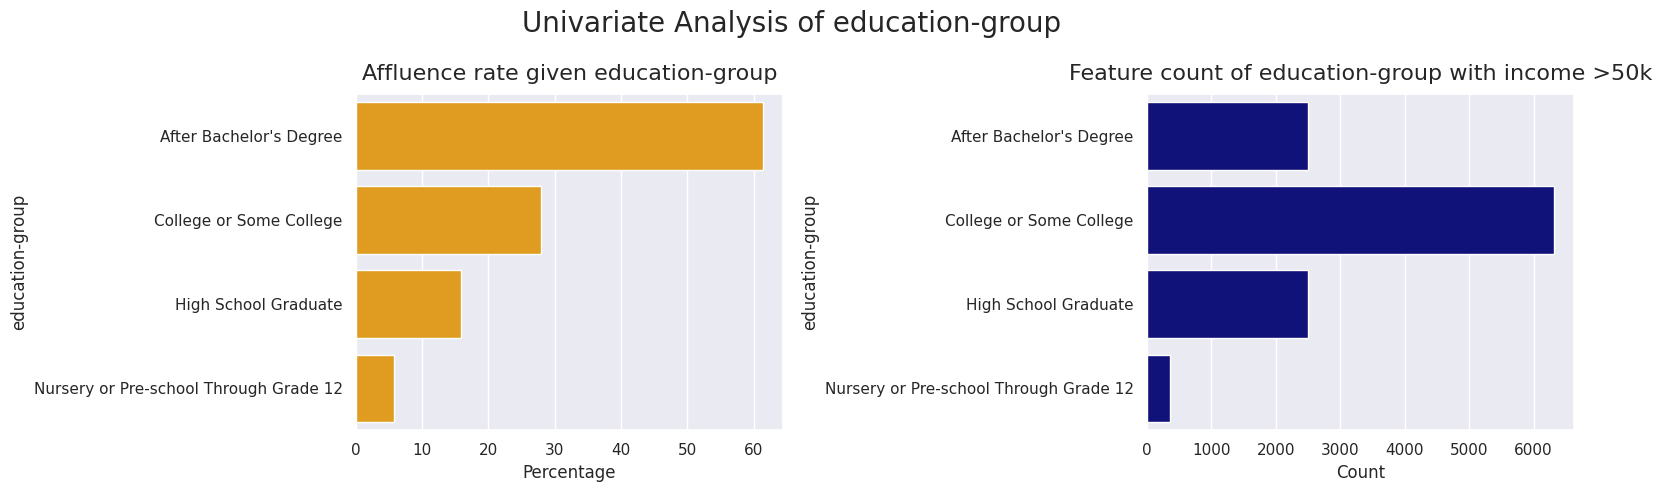

In [25]:
univariate(adult, "education-group", "income")

#### Insights on education

* It can be interpreted from the graph that having a higher degree of education will give someone a greater chance of having an income `>50k`, with those with post-graduate degrees having almost a `61%` chance.

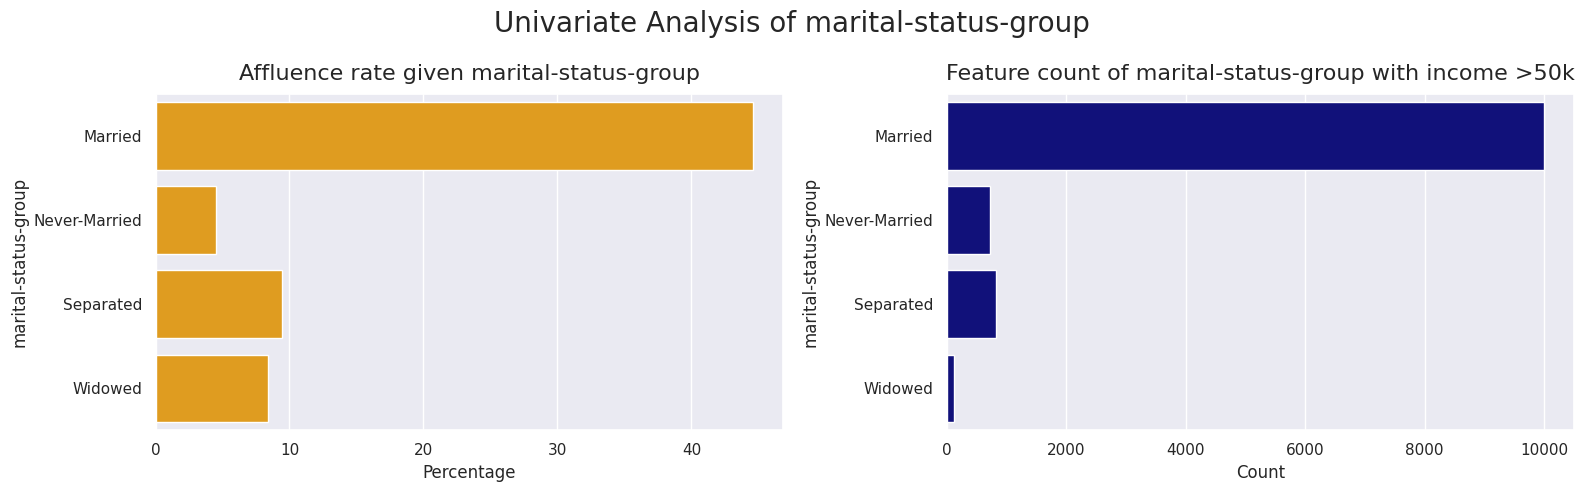

In [26]:
univariate(adult, "marital-status-group", "income")

#### Insights on marital status

* `Married` people are likely to have an income `>50k` compared to other marital status.

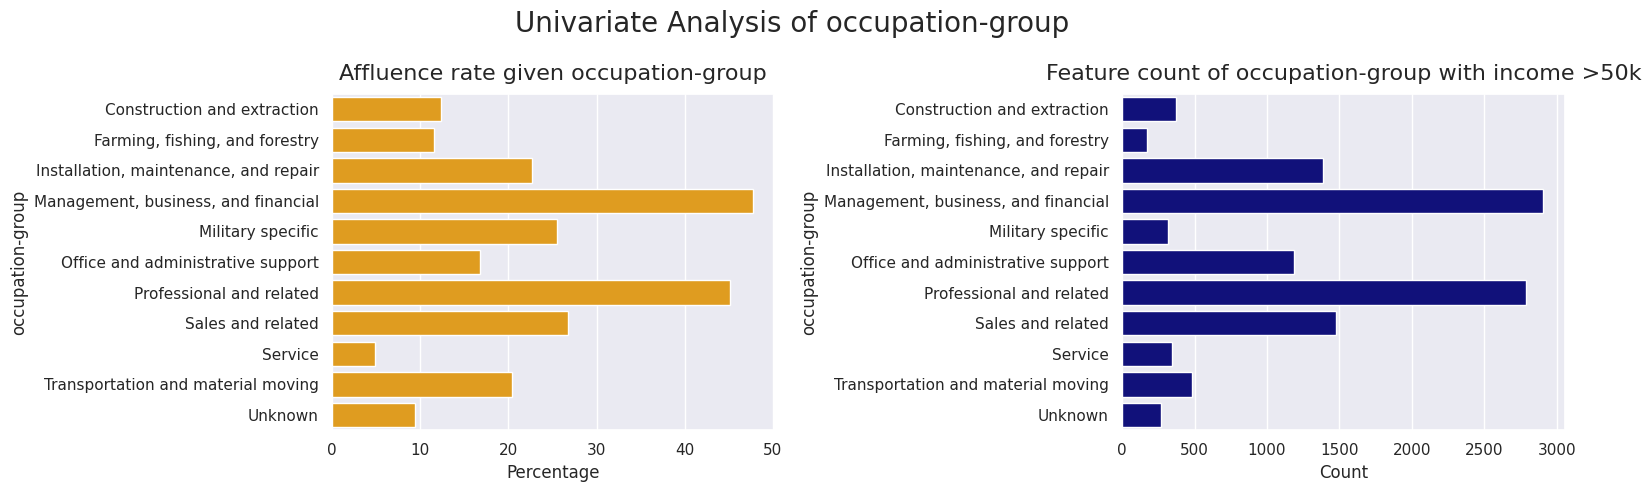

In [27]:
univariate(adult, "occupation-group", "income")

#### Insights on occupation

* `Management, business, finance`, `Professional and related`, and `Sales and related` are the top three occupation groups that are likely to have an income of `>50k`. This three groups are collectively called as *white-collar* jobs that work more in an office setting compared to blue collar jobs that require manual labor.

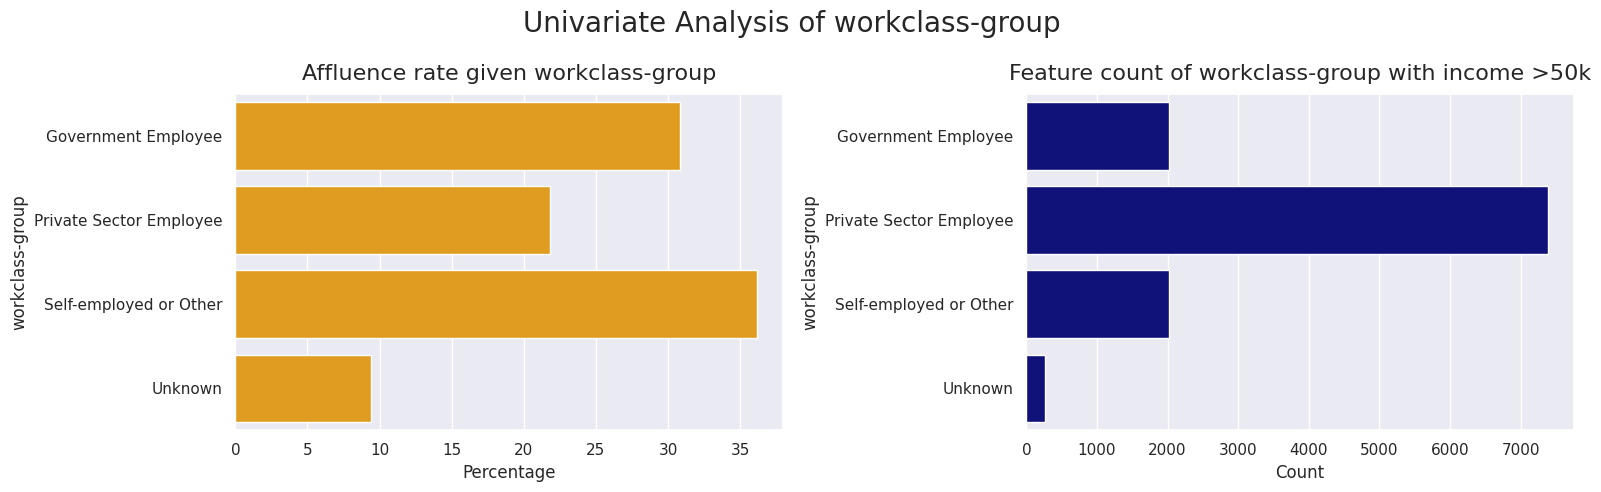

In [28]:
univariate(adult, "workclass-group", "income")

#### Insights on work class

* Though most of the people earning `>50k` came from the private sector, they comprise only of around 22% in the total population of private sector employees. People working in the government or self-employed have a higher chance (>30%) of having an income of `>50k`.

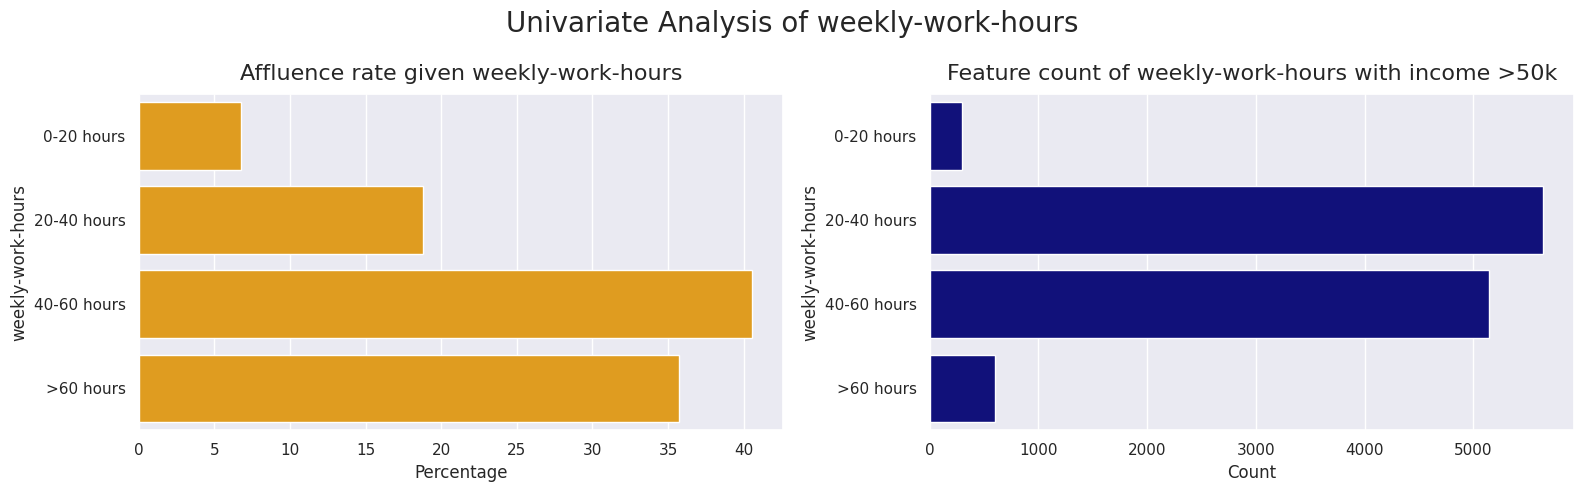

In [29]:
univariate(adult, "weekly-work-hours", "income")

#### Insights on weekly work hours

* People working for more than `40 hours` have a higher chance of earning `>50k` but the data points for `>60 hours` may not be significant due to the low number of counts.

## Bivariate Analysis

In [30]:
def bivariate(df, feature_1, feature_2, target):

    fig, axs = plt.subplots(nrows=len(df[feature_1].unique()),
                               ncols=2,
                               figsize=(12,len(df[feature_1].unique())*5))

    fig.suptitle(f'Bivariate Analysis: {feature_1} vs {feature_2}', fontsize=20, y=1.00)

    for idx, feature in enumerate(sorted(df[feature_1].unique())):
        filtered_df = df[df[feature_1] == feature]

        cont_table = pd.crosstab(filtered_df[feature_2], filtered_df[target], margins=True,)
        cont_prob = cont_table.div(cont_table['All'], axis=0)

        sns.barplot(ax=axs[idx][0],
            x=cont_prob.iloc[:-1][1].values*100,
            y=cont_prob.iloc[:-1][1].index,
            color="orange")

        sns.barplot(ax=axs[idx][1],
                    x=cont_table.iloc[:-1][1].values,
                    y=cont_table.iloc[:-1][1].index,
                    color="darkblue")

        fig.suptitle(f"Bivariate Analysis of {feature_1} vs {feature_2}", fontsize=20, y=1.0)

        axs[idx][0].set_title(f"Affluence rate given \n {feature_1} of '{feature}' \n per {feature_2}",
                              fontsize=16, pad=10)
        axs[idx][1].set_title(f"Feature count with income >50k", fontsize=16, pad=10)

        axs[idx][0].set_xlabel(f"Percentage", fontsize=12)
        axs[idx][1].set_xlabel(f"Count", fontsize=12)


        plt.tight_layout();

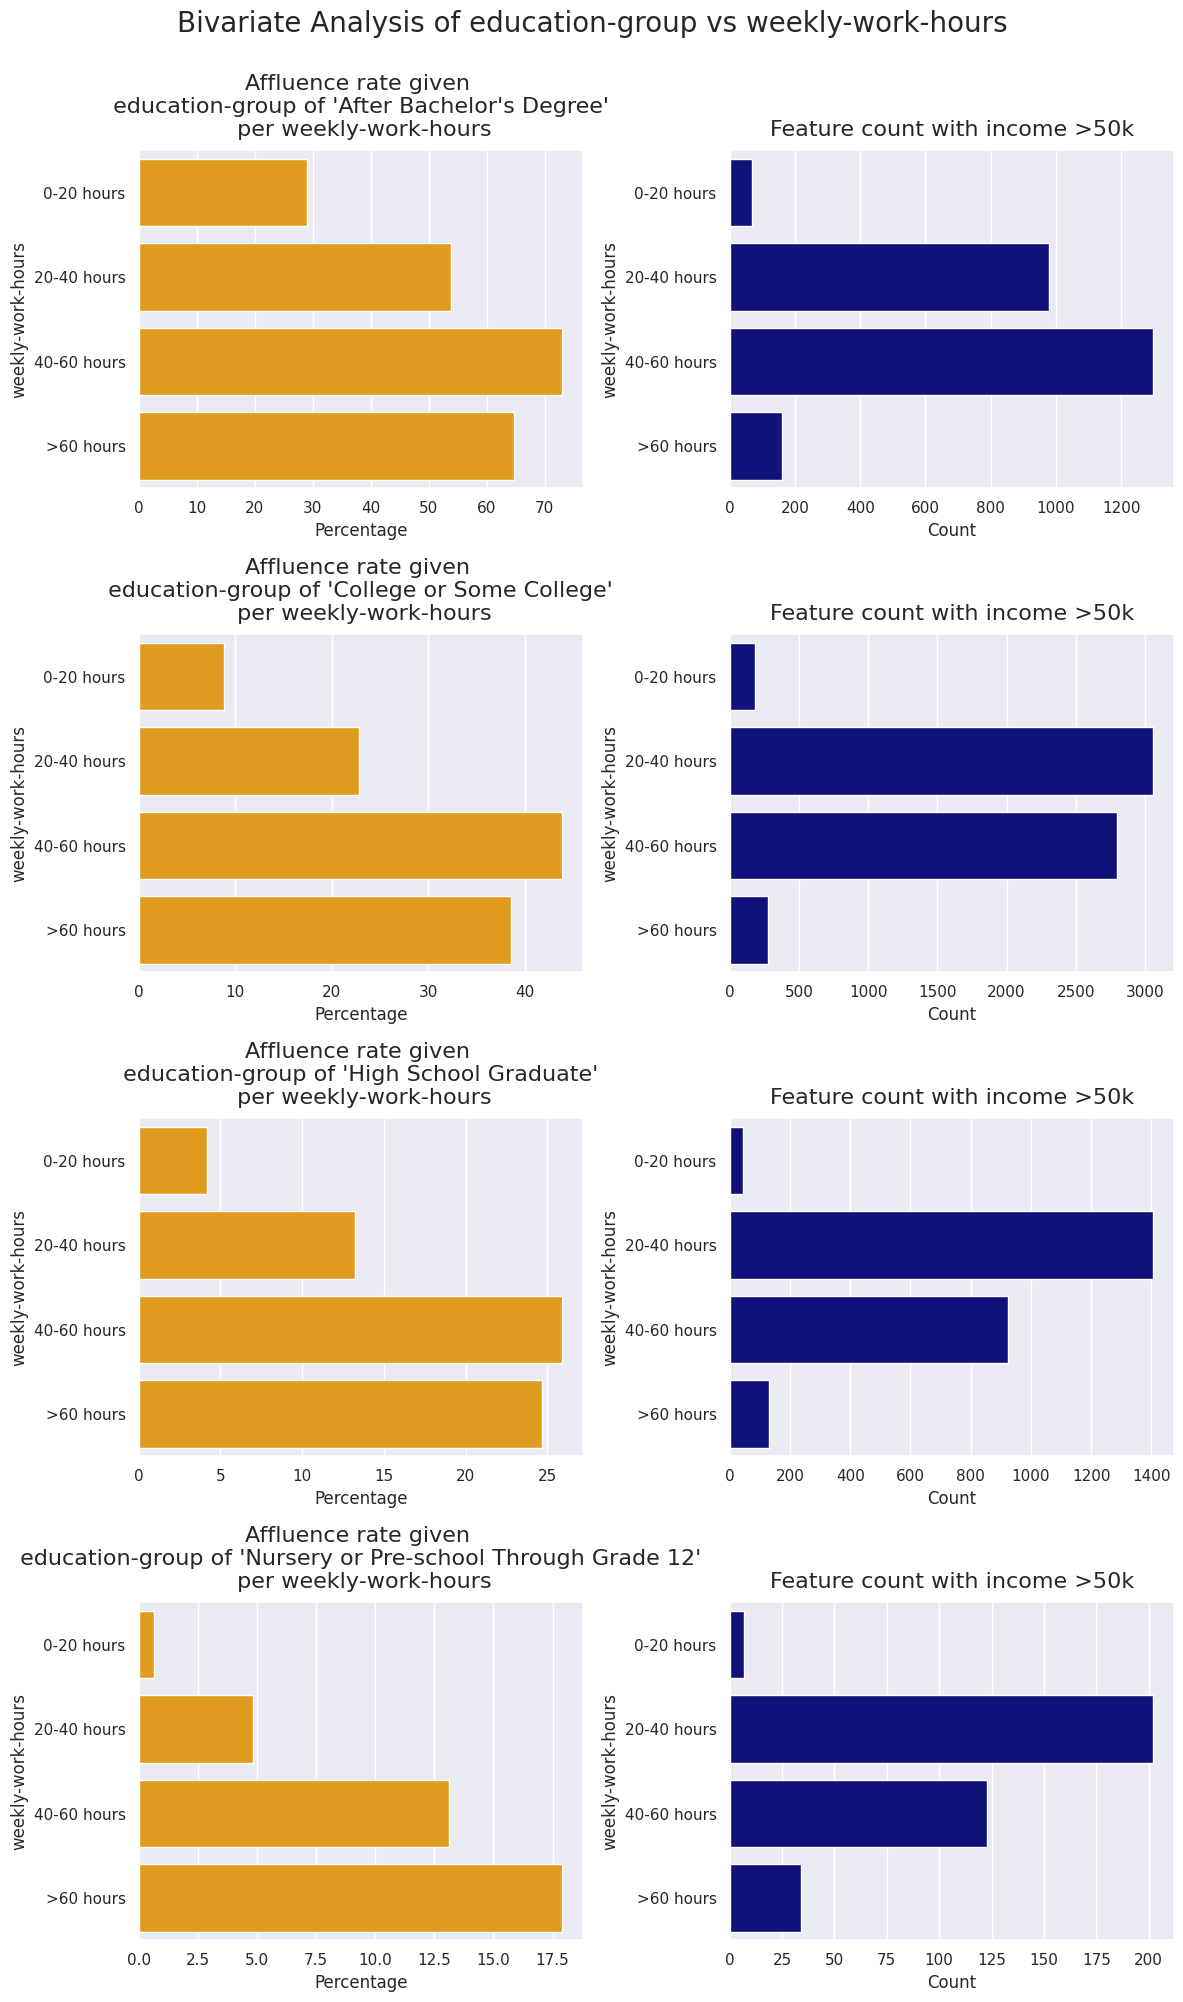

In [31]:
bivariate(adult, 'education-group', 'weekly-work-hours', 'income')

#### Insights on education vs weekly work hours

* Except for those in the `Nursery or Pre-school Through Grade 12`, working up to `60 hours` may likely to increase your chance of having an income `>50k` especially for individuals having higher education.
* On the contrary, `Nursery or Pre-school Through Grade 12` affluence rate is proportional to the number of hours rendered but still less than the base probability of 24%.

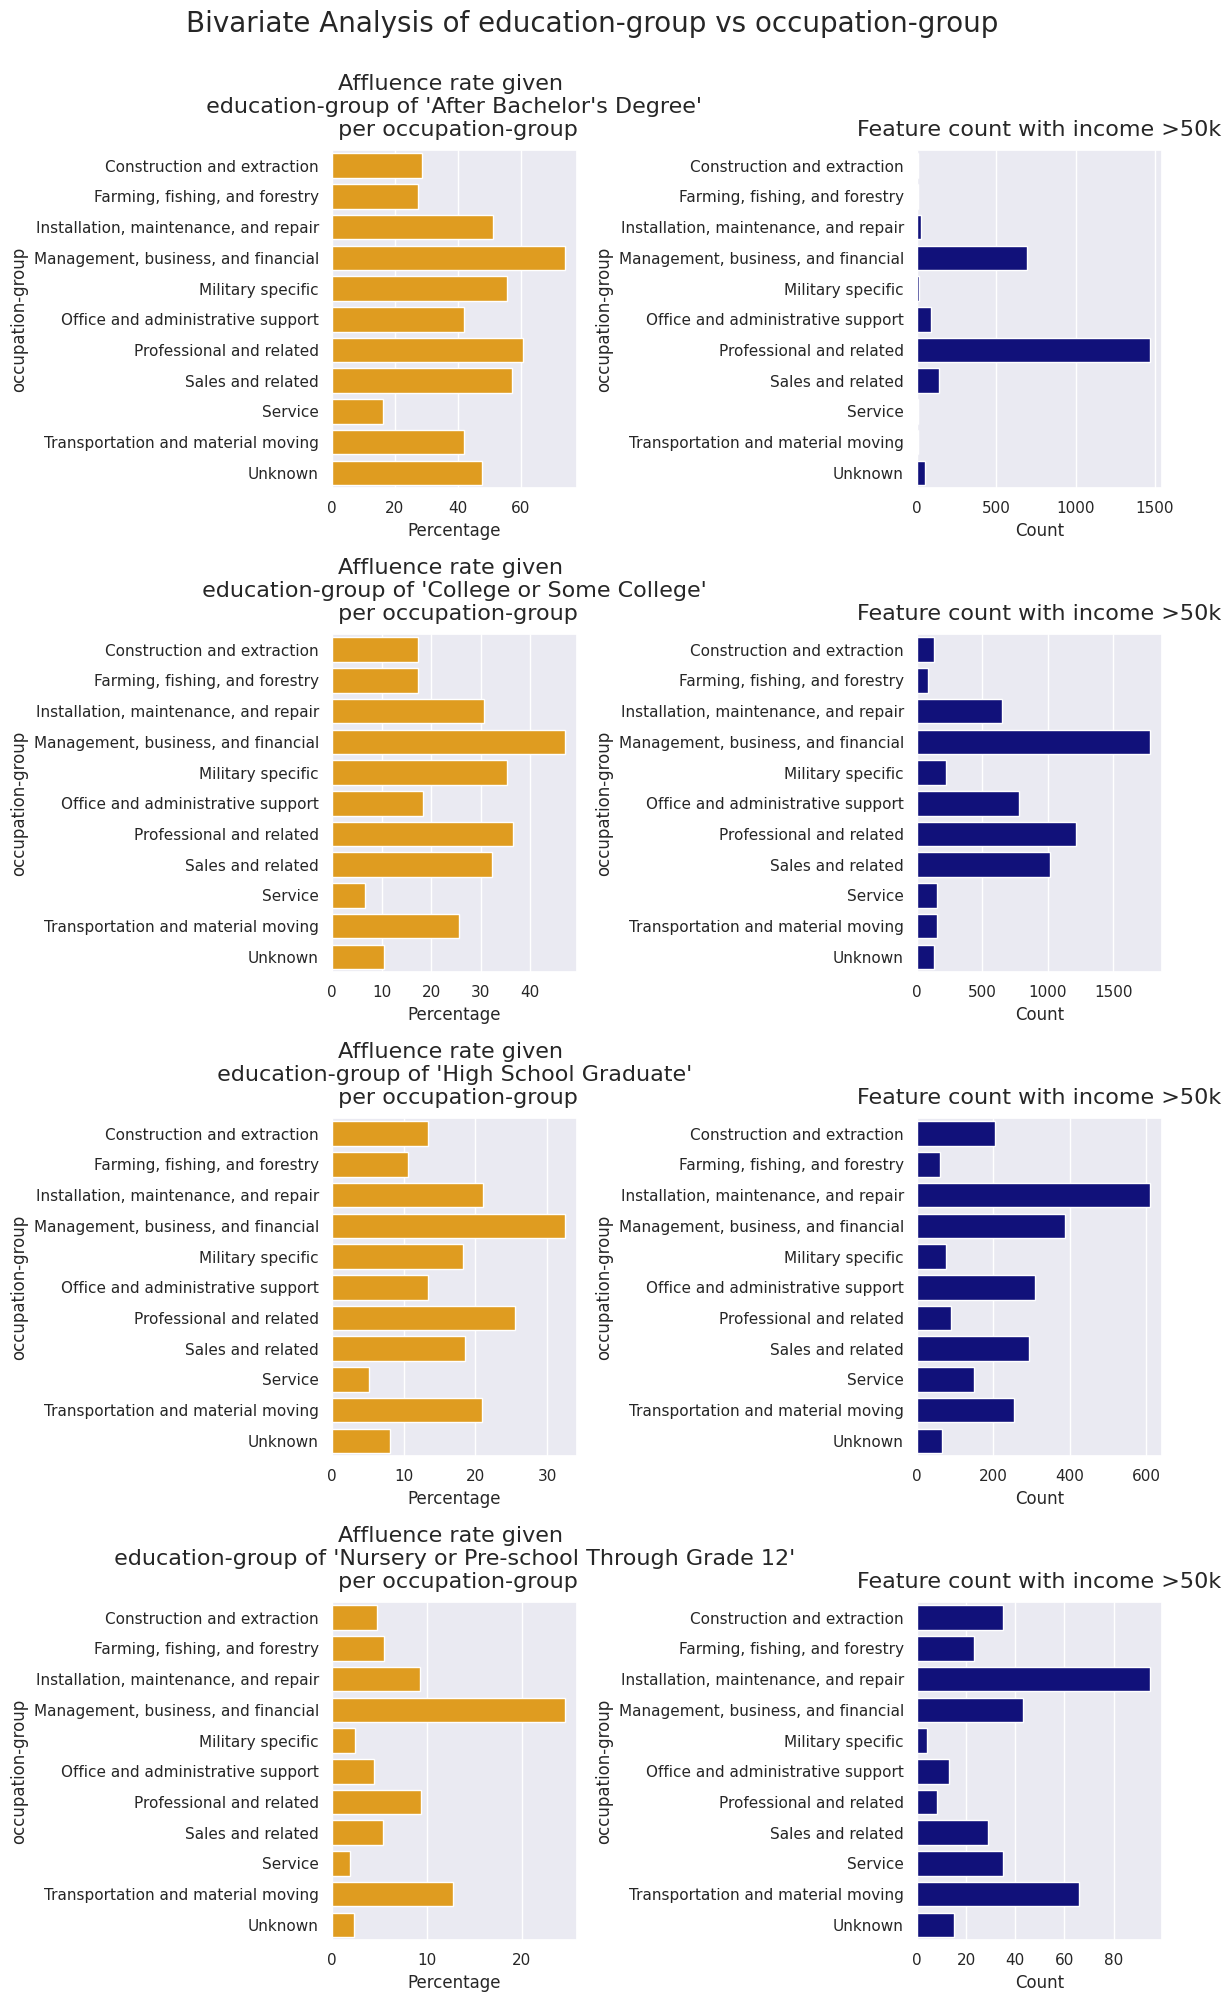

In [32]:
bivariate(adult, 'education-group', 'occupation-group', 'income')

#### Insights on education vs occupation

* `Management, business, and finance`, `Professional and related`, and `Sales and related` are still the top features for people with college and post-graduate degrees. Moreover, people with post-graduate degrees that are working in `management, business, and finance` have 75% chance of having an income `>50k`.

* `Military professionals` ranks third for those with college degrees but the data may not be enough to consider the insight as conclusive.

* For those without college degrees, `installation, maintenance, and repair` and `transportation and material moving` ranks second and third for those with income `>50k` while `management, business, and finance` is still the top occupation.

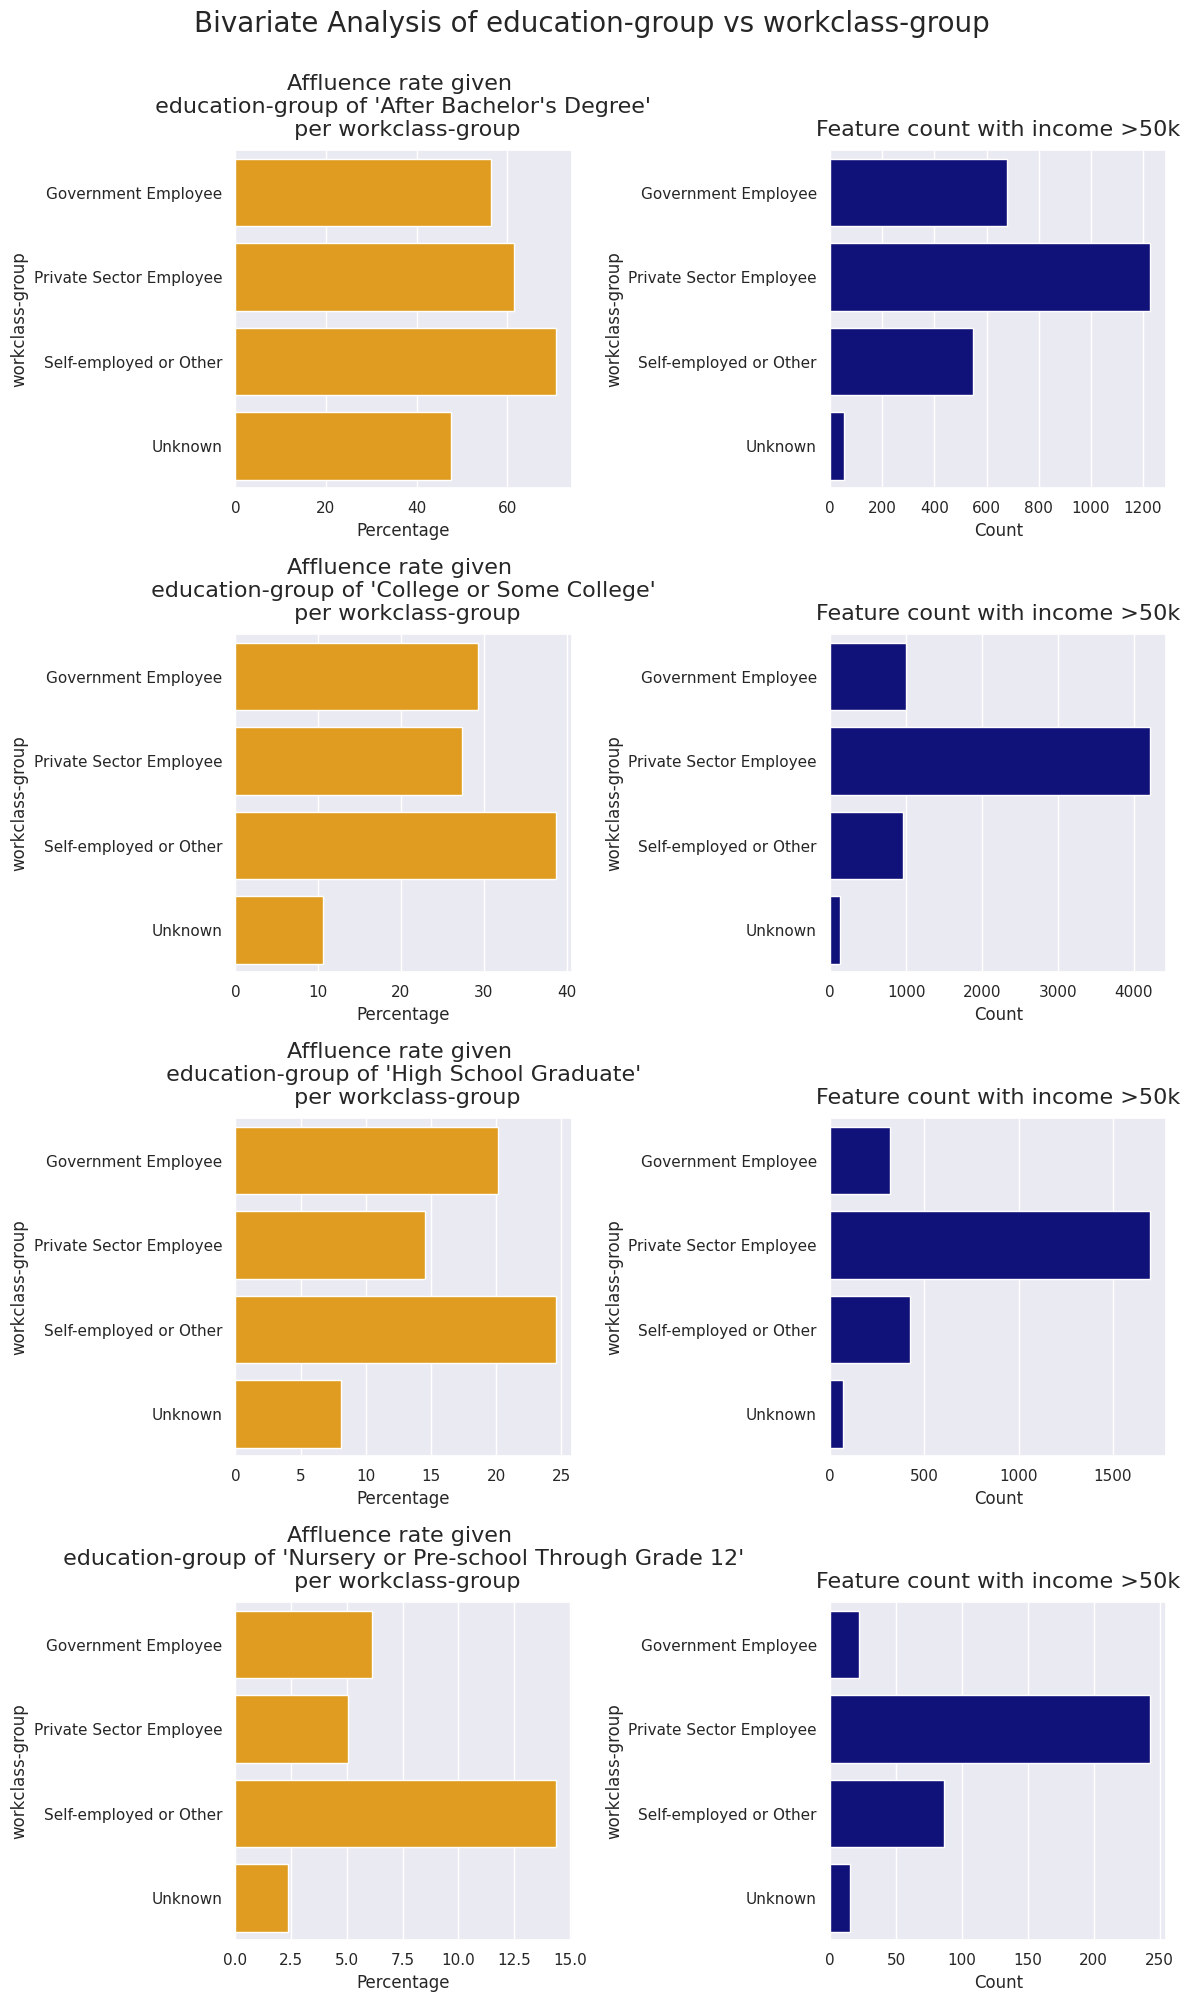

In [33]:
bivariate(adult, 'education-group', 'workclass-group', 'income')

#### Insights on education vs work class

* Among all education groups, being `self-employed` gives the highest likelihood of having an income of `>50k`.
* Except for those with post-graduate degrees, working as a `government employee` yields higher likelihood of earning `>50k` than working in the `private sector`.

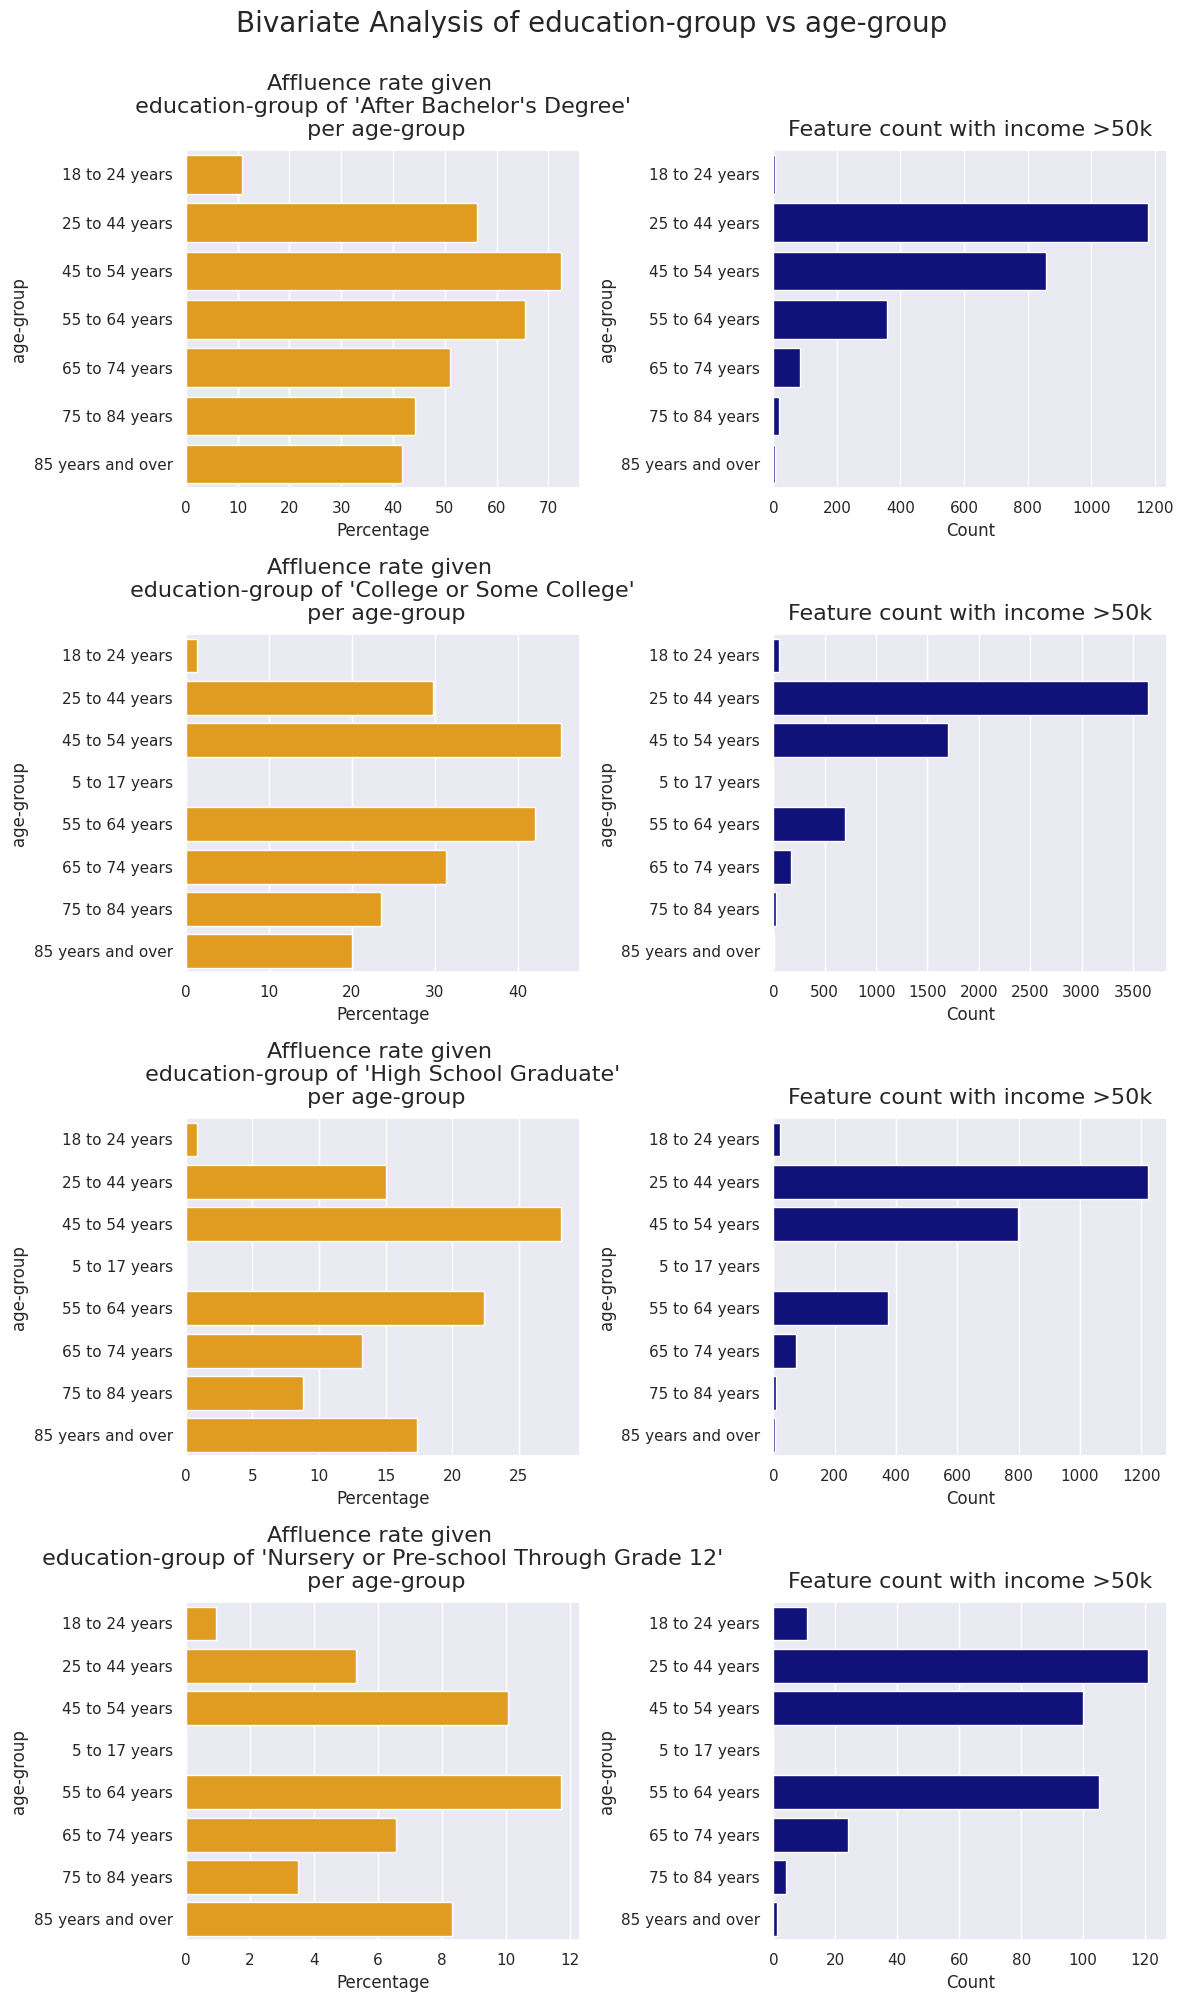

In [34]:
bivariate(adult, 'education-group', 'age-group', 'income')

#### Insights on education vs age

* Age groups between `45 to 54 years` and `55 to 64 years` are highly likely to have an income `>50k` with the probability increasing with higher educational attainment. People with post-graduate degrees within the age of `45 to 54 years` have 72% chance of having an income of `>50k`.
* On the contrary, those with educational attainment less than a high school graduate are more likely to have an income `>50k` at the age group of `55 to 64 years` but the data points is only around 100 which makes this insight inconclusive.

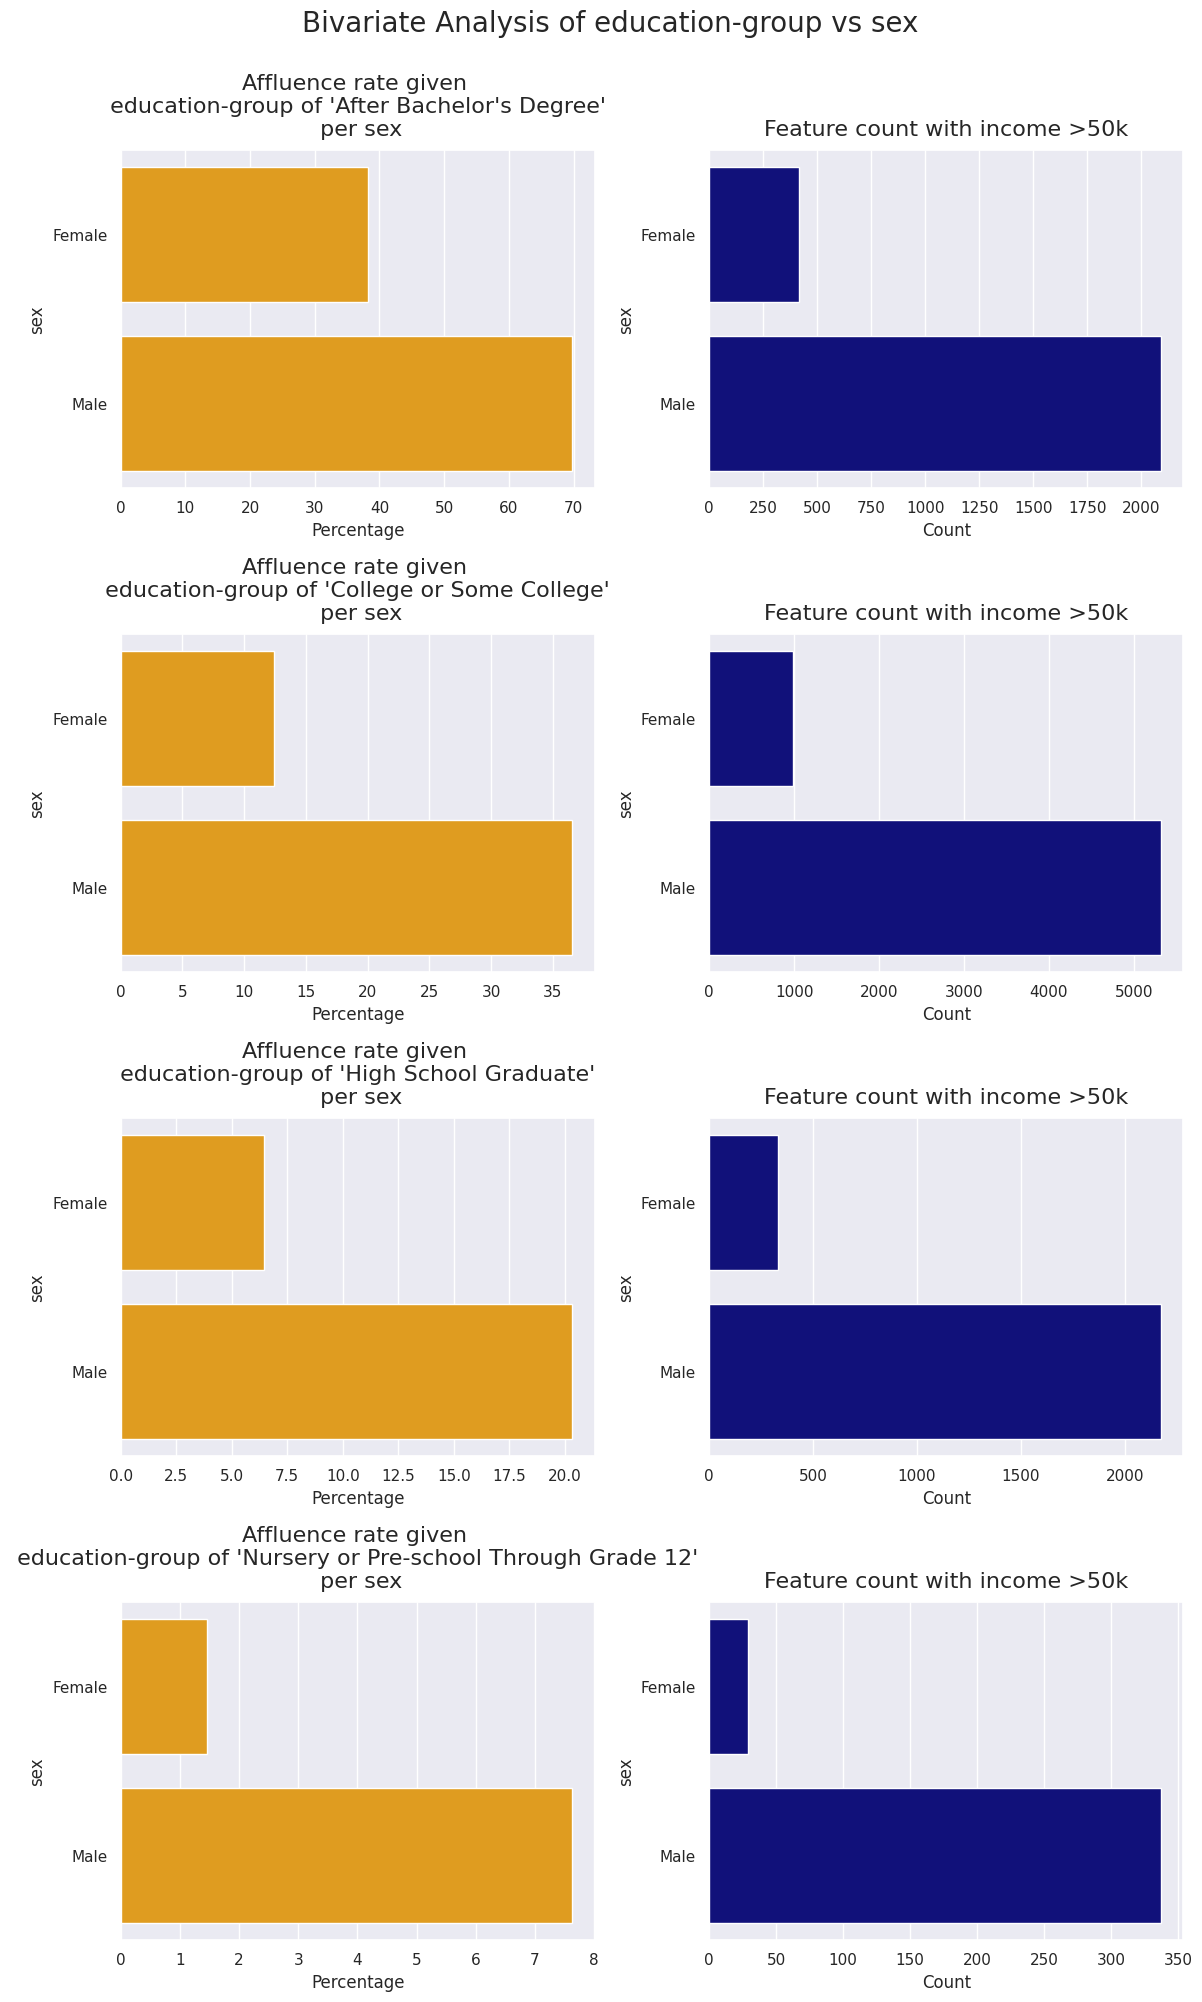

In [35]:
bivariate(adult, 'education-group', 'sex', 'income')

#### Insights on education vs age

* Given the same educational attainment, `males` are more likely to have an income `>50k` than `females`.

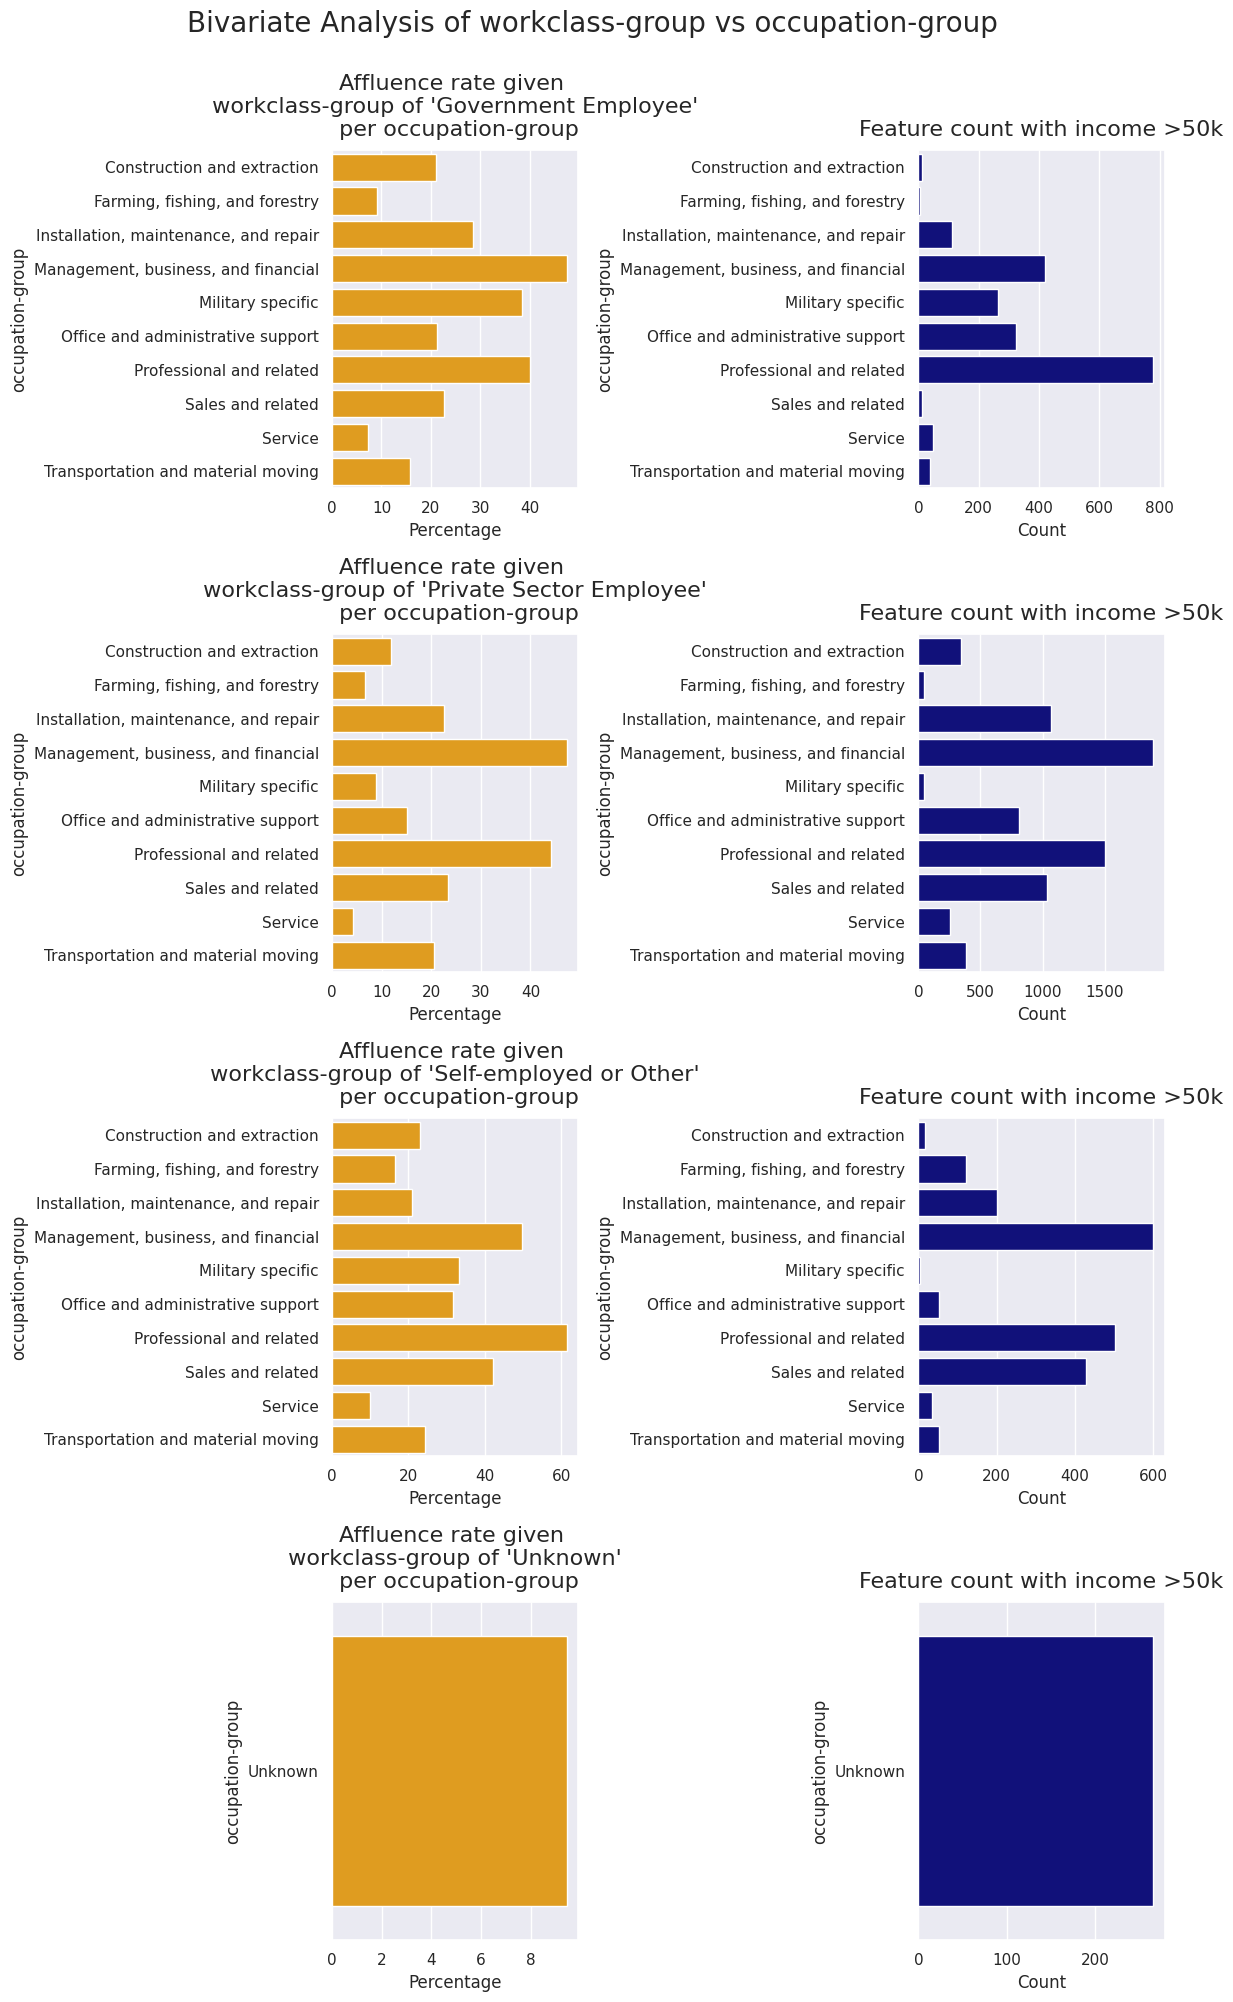

In [36]:
bivariate(adult, 'workclass-group', 'occupation-group', 'income')

#### Insights on work class vs education

* Except for `government employee`, `management, business, finance`, `professional and related`, and `sales and related` are still the top indicator of having an income `>50k`. On the other hand, `military specific` and `professional and related` have close probabilities for people earning `>50k`.
* Surprisingly, there are `unknown` jobs under `unknown` class groups that are earning `>50k`.

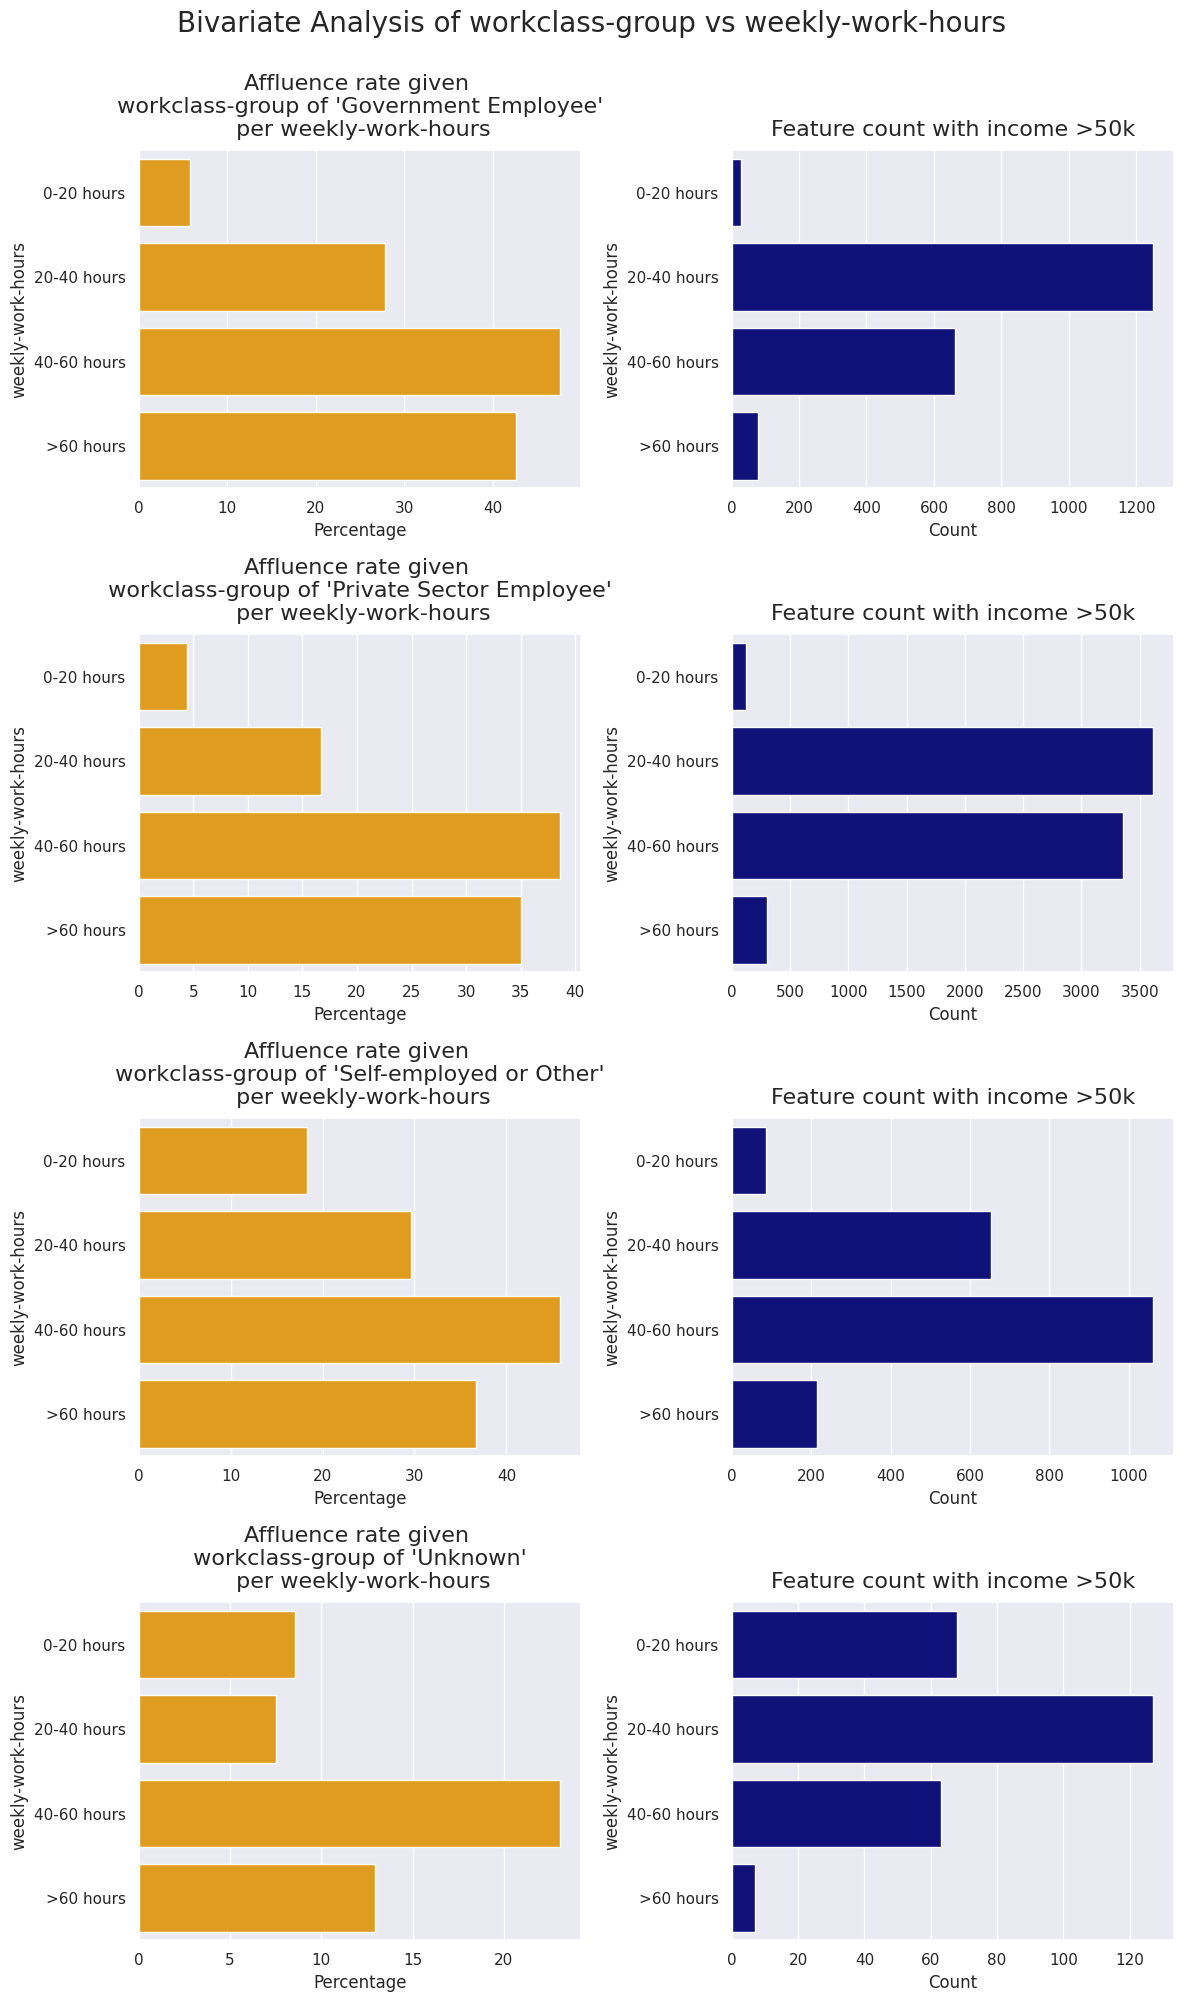

In [37]:
bivariate(adult, 'workclass-group', 'weekly-work-hours', 'income')

#### Insights on work class vs weekly work hours

* Regardless of workclass, working for `40 - 60 hours` is the top indicator for having an income `>50k`. This could mean that `weekly-work-hours` is a stronger feature than the `workclass-group`.

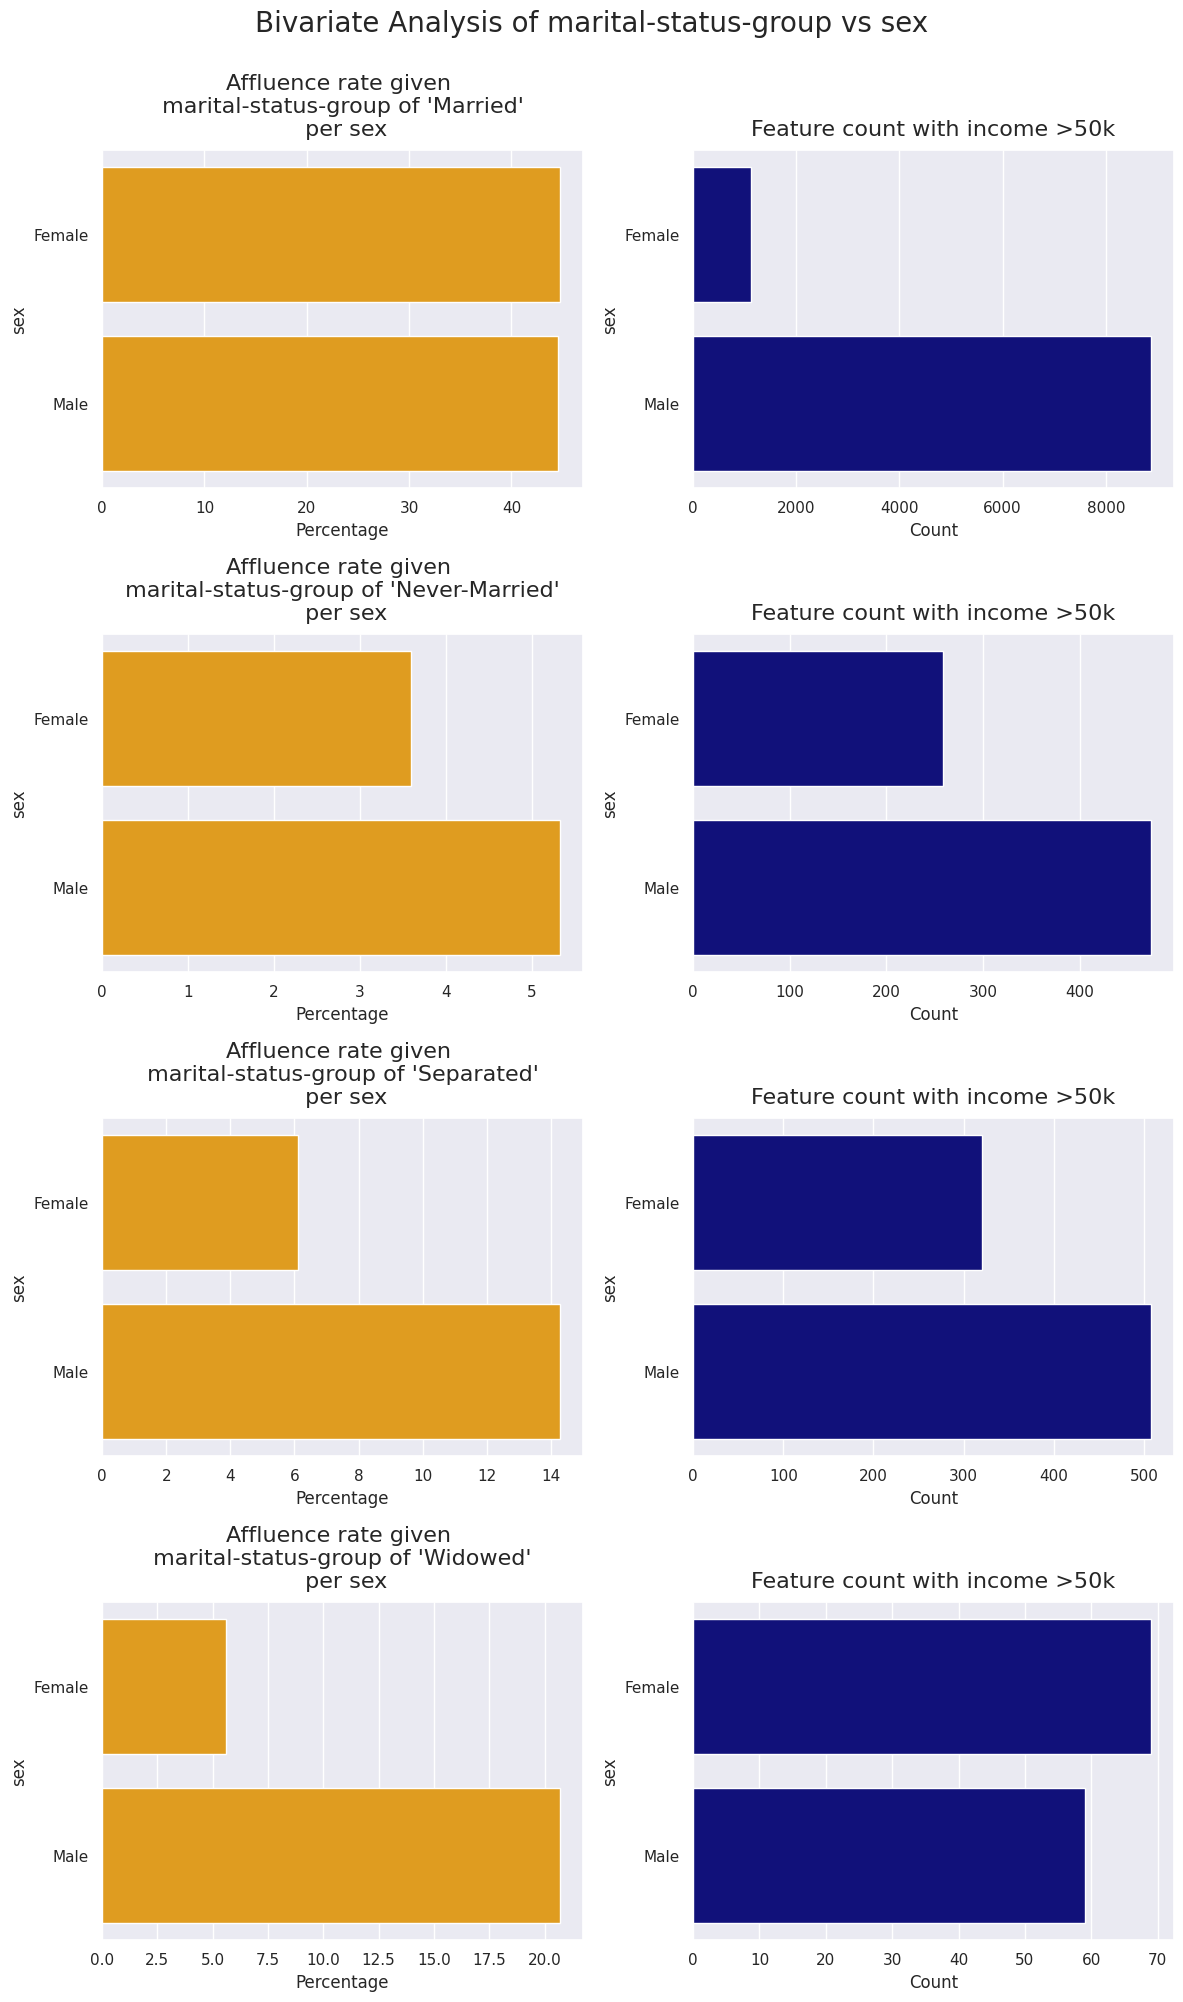

In [38]:
bivariate(adult, 'marital-status-group', 'sex', 'income')

#### Insights on marital status vs sex

* For `married` and `never-married` people, `male` and `female` has an equal chance of getting an income `>50k`.
* For `separated` and `widowed` people, `males` are more likely to have a higher chance of having an income `>50k`.

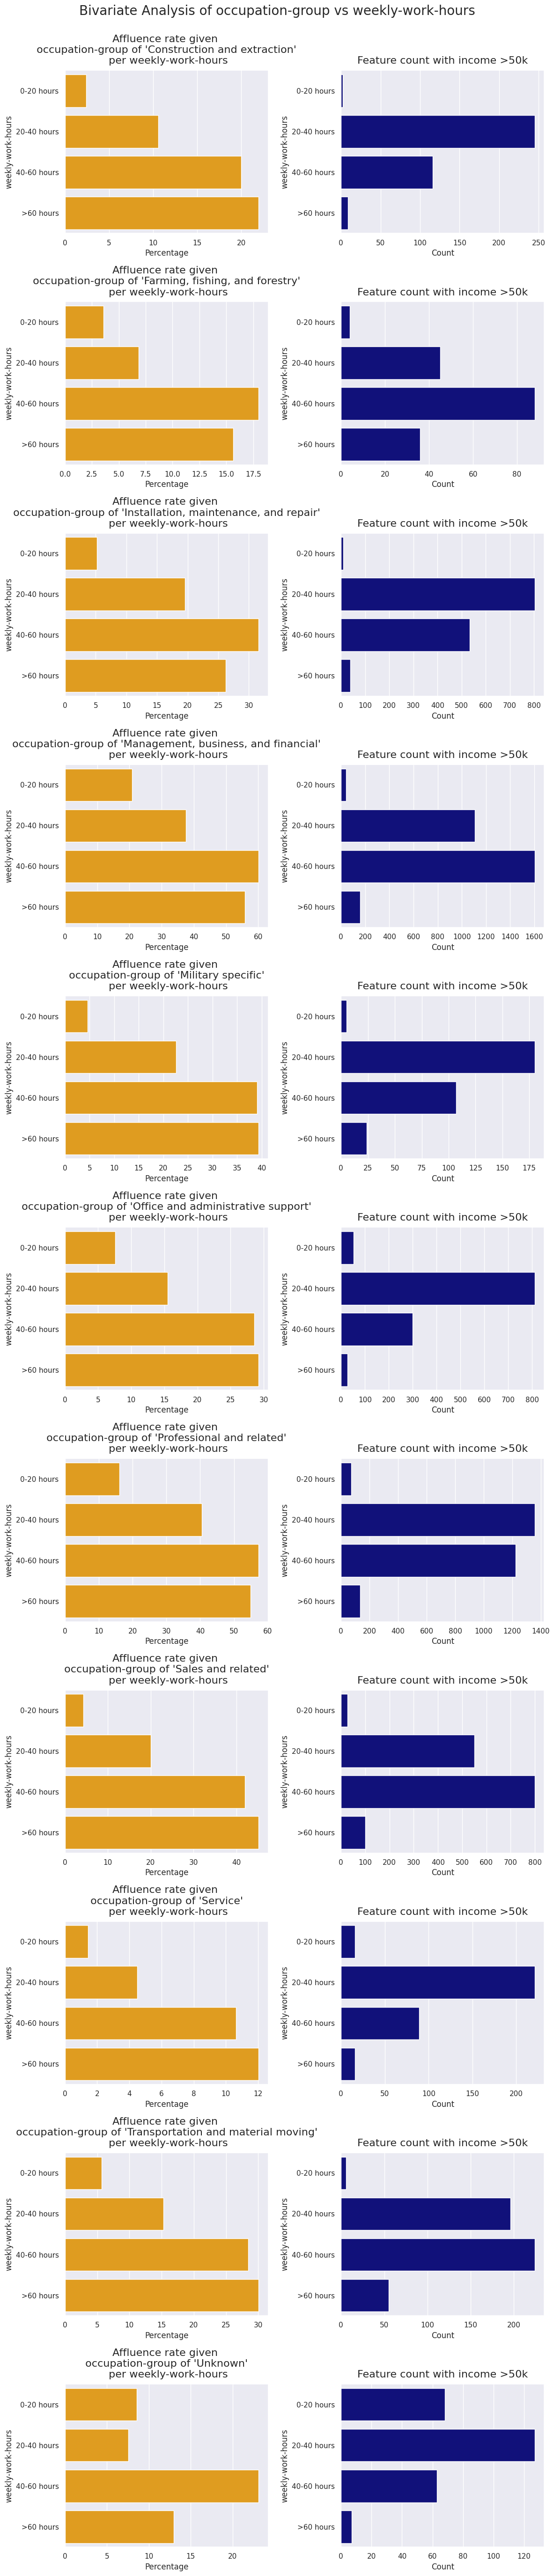

In [39]:
bivariate(adult, 'occupation-group', 'weekly-work-hours', 'income')

#### Insights on occupation vs weekly work hours

* Working for `>60 hours` in `management, business, and finance` and `professional and related` does not increase the probability of having an income `>50k`.
* The general trend shows that the chance of having an income `>50k` increases as you put in more hours but working for more than 60 hours has diminishing returns except for some occupations (`Construction and extraction`, `military specific`, `Office and administrative support`, and `transportation and material moving`).

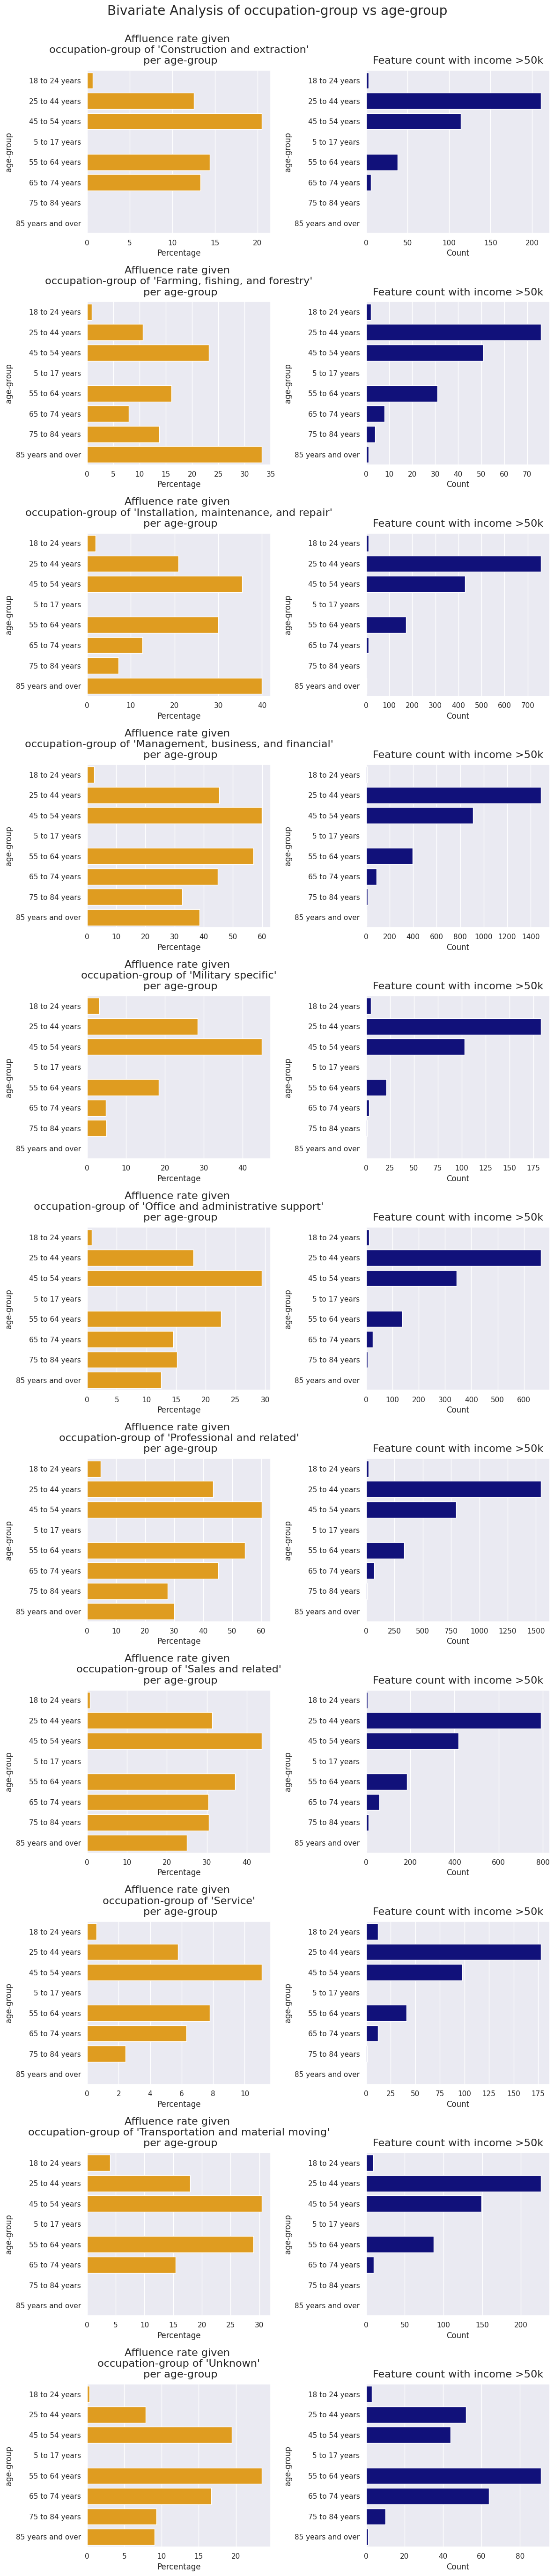

In [40]:
bivariate(adult, 'occupation-group', 'age-group', 'income')

#### Insights on occupation vs age

* Regardless of occupation, the trend follows the same pattern from the univariate analysis of `age-group` which shows that having an income of `>50k` peaks at `45 to 54 years`.

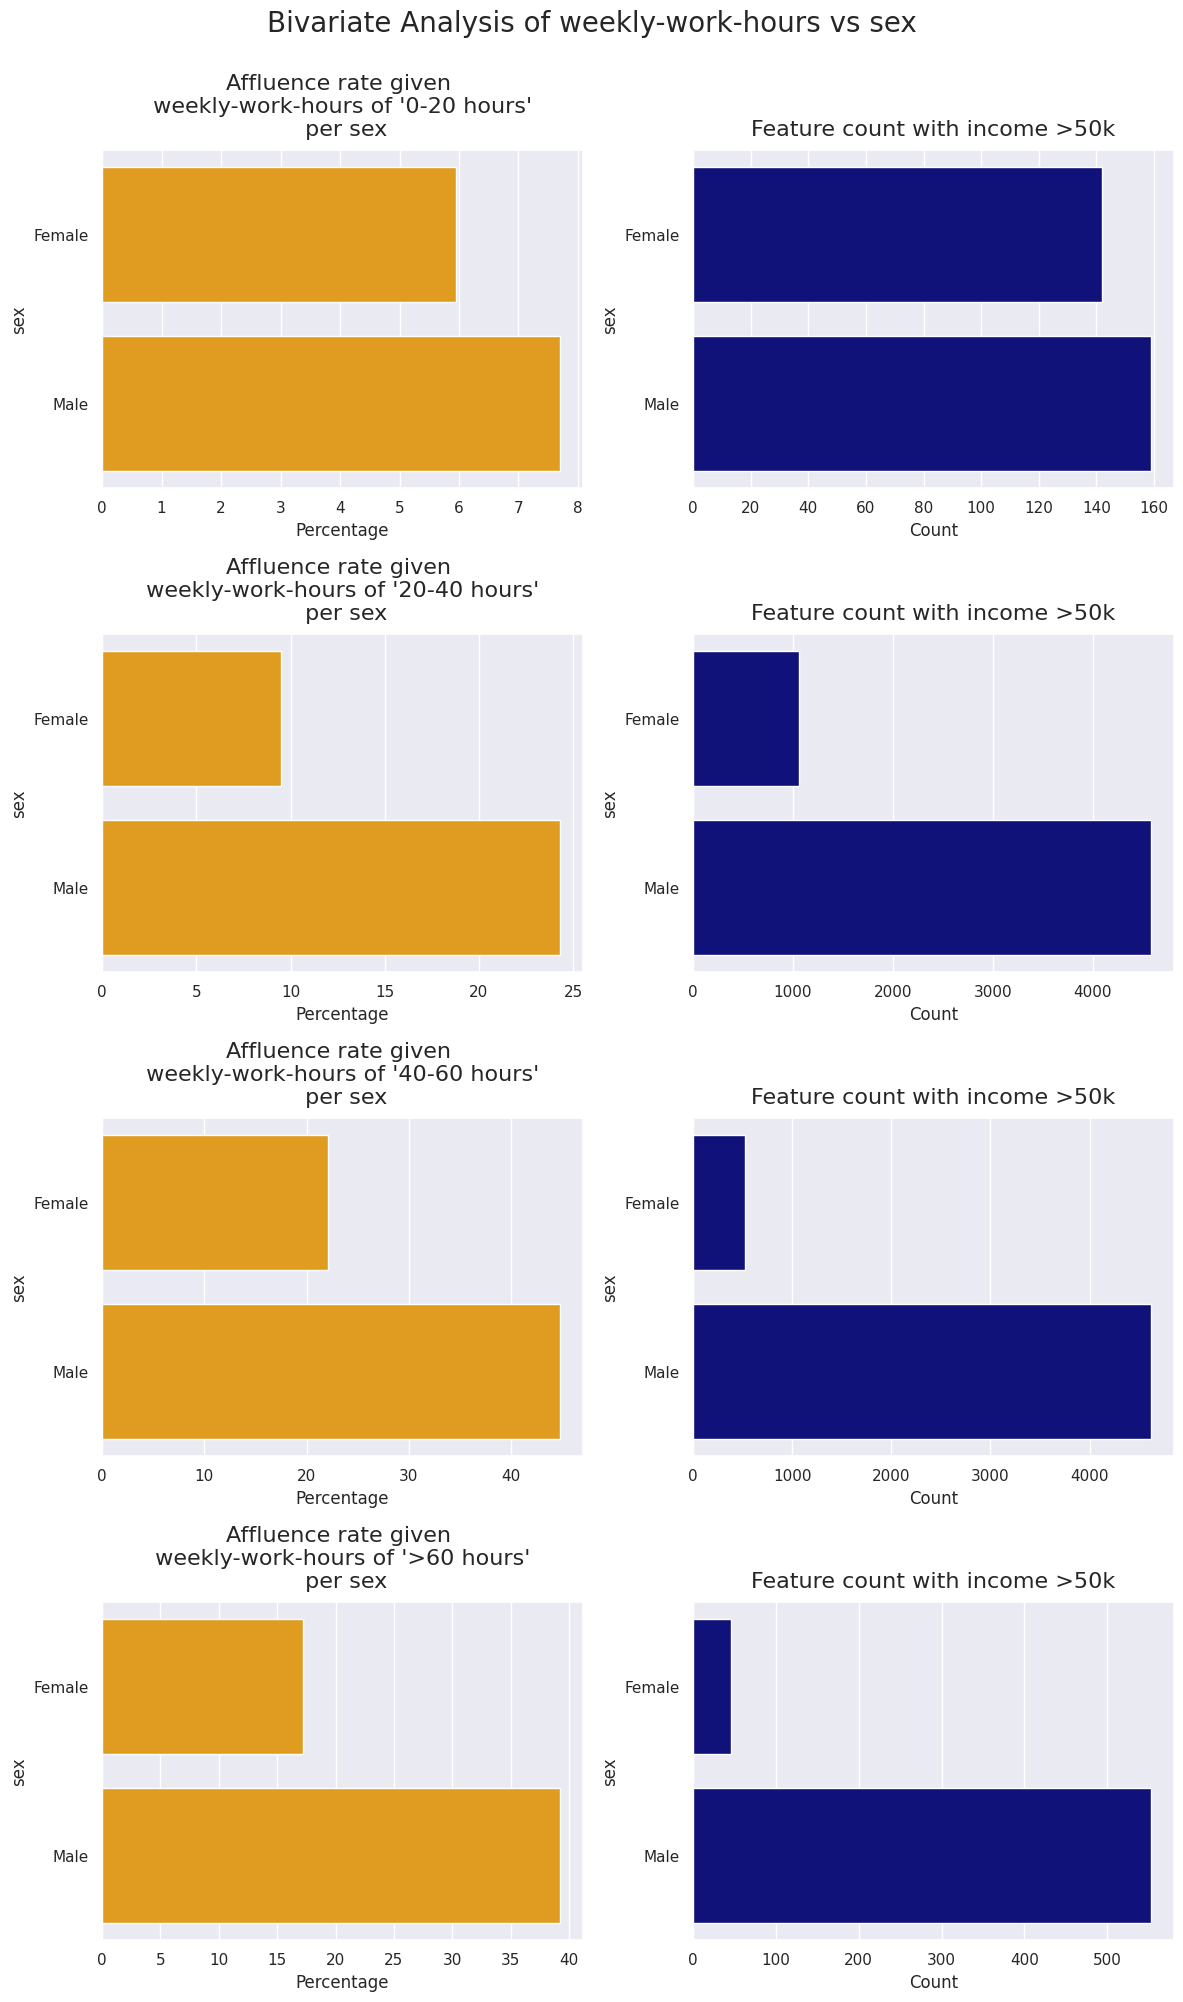

In [41]:
bivariate(adult, 'weekly-work-hours', 'sex', 'income')

#### Insights on weekly work hours vs sex

* `Males` working for more than 20 hours have almost twice the probability of having an income `>50k` than `females`.

## Machine Learning Models and Review of Related Literatures

The data set is popular and has been used in a handful of machine learning papers. Here we'll provide 6 of them and focus on the first 3

> [[1] A Statistical Approach to Adult Census Income Level Prediction](https://www.researchgate.net/publication/334168241_A_Statistical_Approach_to_Adult_Census_Income_Level_Prediction)

> [[2] Predicting Annual Income of Individuals using Classification Techniques](https://www.researchgate.net/publication/370683521_Predicting_Annual_Income_of_Individuals_using_Classification_Techniques)

> [[3] Classification of Adult Income Using Decision Tree](https://stars.library.ucf.edu/cgi/viewcontent.cgi?article=1002&context=data-science-mining)

> [[4] A Comparison of Supervised Learning Algorithms for the Income Classification](https://www.ijcaonline.org/archives/volume182/number38/temraz-2019-ijca-918391.pdf)

> [[5] A Comparative Study of Classification Techniques On Adult Data Set](https://www.ijert.org/research/a-comparative-study-of-classification-techniques-on-adult-data-set-IJERTV1IS8243.pdf)

> [[6] Performance Assessment of Feature Selection methods using K-means on Adult Dataset](https://www.researchgate.net/publication/299391298_Performance_Assessment_of_Feature_Selection_methods_using_K-means_on_Adult_Dataset?_tp=eyJjb250ZXh0Ijp7InBhZ2UiOiJwdWJsaWNhdGlvbiIsInByZXZpb3VzUGFnZSI6bnVsbH19)




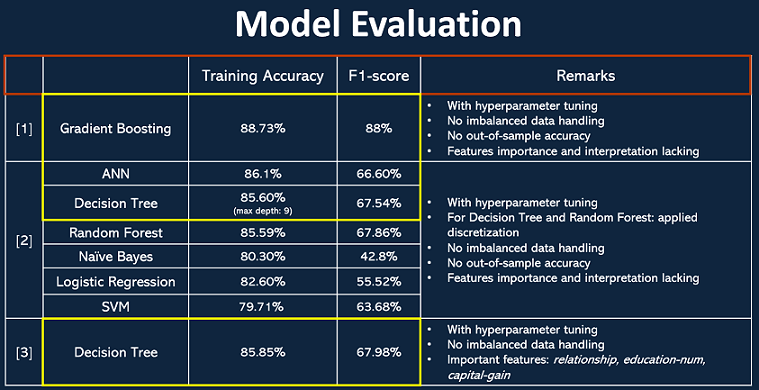

### Supplementary

Using the features processed during the group's EDA, check if **Gradient Boosting** (top model from RRL) achieves same level of accuracy with interpretable results​

In [42]:
%%capture

! pip install shap
! pip uninstall scikit-learn -y
! pip install -U scikit-learn==1.3.2

This may require environment restart in Google Collab. Required version for scikit-learn 1.3.0 or up

In [43]:
import sklearn
sklearn.__version__

'1.3.2'

In [44]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
import shap
import pandas as pd
import numpy as np

In [45]:
# Down sample rows to the number of target feature (minority class)
def downsample(df, feature, majority, minority):
    df_majority = df[df[feature]==majority]
    df_minority = df[df[feature]==minority]

    df_minority_downsampled = resample(df_majority,
                                     replace=True,
                                     n_samples= len(df_minority),
                                     random_state=55)

    df_downsampled = pd.concat([df_minority_downsampled, df_minority]).reset_index(drop=True)
    return df_downsampled

In [46]:
# Assign custom field combiner for One Hot Encoding
def custom_combiner(feature, category):
        return str(feature) + "_" + type(category).__name__ + "_" + str(category)

In [47]:
# Show confusion matrix and classification report
def confusion_matrix_viz(y_test, y_pred):
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

    print(classification_report(y_test, y_pred, digits=4))

In [48]:
# Explain important attributes using SHAP
def explain_ensemble_model(model, X_test, feature_names, method=None):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(pd.DataFrame(X_test.toarray()), approximate=False, check_additivity=False)

    fig = plt.gcf()
    shap.summary_plot(shap_values, pd.DataFrame(X_test.toarray()), feature_names=feature_names)

In [49]:
# Split and encode categorical features in training data
def split_encode(df_data, target, split_ratio=0.25, random_state=0):
    df_targ = df_data[target]
    df_feats = df_data.drop(target, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(df_feats, df_targ,
                                                    test_size=split_ratio,
                                                    random_state=random_state)

    encoder = OneHotEncoder(feature_name_combiner=custom_combiner)
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    model_data = {'X_train': X_train_encoded,
                  'X_test': X_test_encoded,
                  'y_train': y_train,
                  'y_test': y_test,
                  'features': df_feats.columns,
                  'encoded_features': encoder.get_feature_names_out()}

    return model_data

In [50]:
def evaluate_model(train_test_df, df_val, training_features, target_feature, trim_features=True, gs_option=False):

    model_data = split_encode(train_test_df[training_features+[target_feature]],
                             target_feature,
                             split_ratio=0.25,
                             random_state=55)

    X_train = model_data['X_train']
    y_train = model_data['y_train']
    X_test = model_data['X_test']
    y_test = model_data['y_test']

    model = GradientBoostingClassifier().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    confusion_matrix_viz(y_test, y_pred)
    explain_ensemble_model(model, X_test, feature_names=model_data['encoded_features'])

    # Perform inference on out-of-sample data
    print('------------------------------------------------')
    print('Performing out of sample testing')

    df_processed_val = df_val
    X_val = df_processed_val.drop([target_feature], axis=1)[training_features]
    y_val = df_processed_val[target_feature].values

    encoder = OneHotEncoder(feature_name_combiner=custom_combiner)
    X_val = encoder.fit_transform(X_val)

    y_pred_val = model.predict(X_val)
    confusion_matrix_viz(y_val, y_pred_val)

In [51]:
# Keep 80% of data for train-test, 20% for out-of-sample​ testing
adult_full = adult.copy()
adult = adult_full.sample(frac=0.80, random_state=55)
adult_oos = adult_full.drop(adult.index)

print('Full shape: ' + str(adult_full.shape))
print('Train-test shape: ' + str(adult.shape))
print('Out-of-sample set: ' + str(adult_oos.shape))

target_feature = 'income'
df_targ = adult[target_feature]
df_feats = adult.drop(target_feature, axis=1)

df_resampled = downsample(adult, feature=target_feature, majority=False, minority=True)
train_test_features = df_resampled.columns.drop([target_feature]).tolist()

print('Data size before trimming: ', len(adult))
print('Resampled size: ', len(df_resampled))
print(df_resampled[target_feature].value_counts())

Full shape: (48842, 9)
Train-test shape: (39074, 9)
Out-of-sample set: (9768, 9)
Data size before trimming:  39074
Resampled size:  18752
0    9376
1    9376
Name: income, dtype: int64


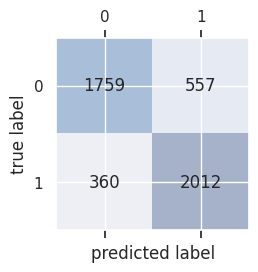

              precision    recall  f1-score   support

           0     0.8301    0.7595    0.7932      2316
           1     0.7832    0.8482    0.8144      2372

    accuracy                         0.8044      4688
   macro avg     0.8066    0.8039    0.8038      4688
weighted avg     0.8064    0.8044    0.8039      4688



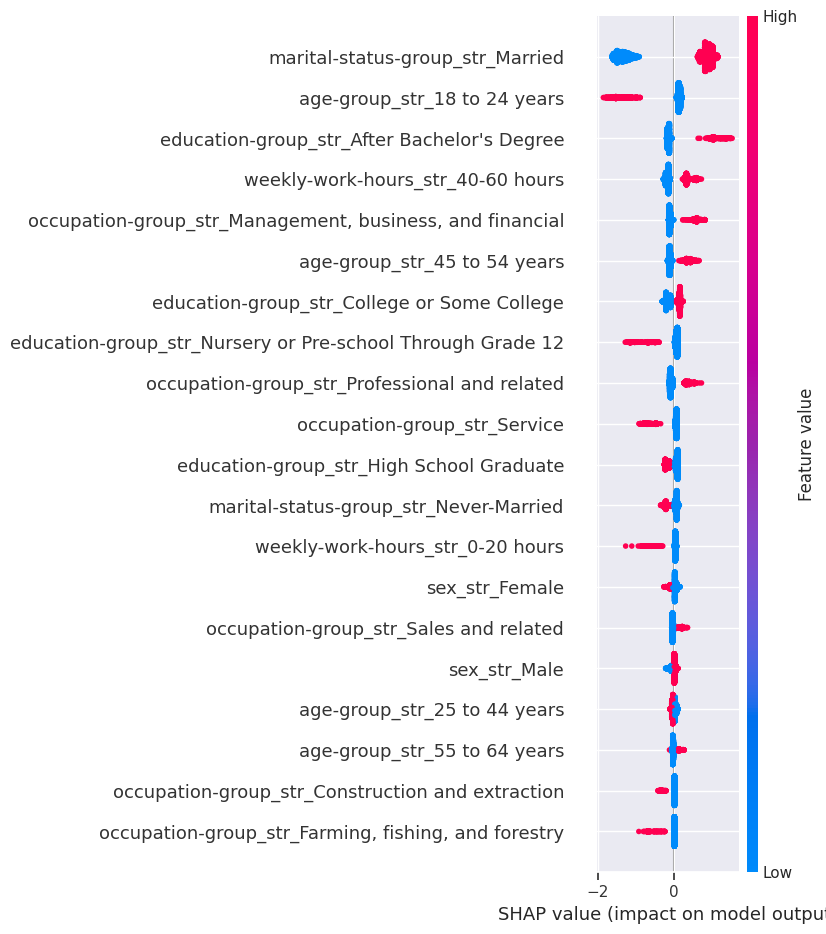

------------------------------------------------
Performing out of sample testing


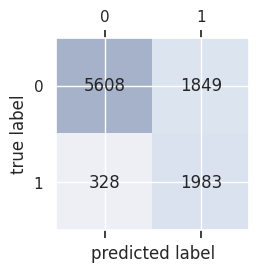

              precision    recall  f1-score   support

           0     0.9447    0.7520    0.8375      7457
           1     0.5175    0.8581    0.6456      2311

    accuracy                         0.7771      9768
   macro avg     0.7311    0.8051    0.7415      9768
weighted avg     0.8437    0.7771    0.7921      9768



In [52]:
shap_trimmed = evaluate_model(df_resampled, adult_oos, train_test_features, target_feature)

### Insights
-  Gradient Boosting Model based on the data set prepared by the team through various EDA considerations, achieved 80.44% training accuracy with out-of-sample test not lagging much behind at 77.71%. This suggests that the model performed fairly well without overfitting on the training data.
- While Gradient Boosting in Paper [2] achieved 88% training accuracy, without out-of-sample test accuracy to compare this on, we are not sure if we can conclude the same.
- The top 5 features by importance are below and how they impact the model output:
  - Being `married` (*positively* impacts)
  - Being in `age group 18-24 years old` (*negatively* impacts)
  - Acquiring a `post-Bachelor's degree` (*positively* impacts)
  - Working `40-60 hours weekly` (*positively* impacts)
  - Having an occupation around `Management, business and financial` (*positively* impacts)
- The top features align with the insights discovered during Univariate Analysis